# Compare vaccination strategies per ERVA and age groups. $e$=0.7

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS
from matplotlib.lines import Line2D

mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
taus = EXPERIMENTS['taus']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']
e = EPIDEMIC['e']
strategies = EXPERIMENTS['strategies']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']
color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
len_bar = 5
sep_bet_group = 4*len_bar
legend_width = 4

begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
ts = [begin + datetime.timedelta(days=day) for day in range(T)]
print('Simulation ends: %s' % (ts[-1]))
t2 = int(T-1)
t1 = t2-30

Simulation ends: 2021-08-10 00:00:00


In [3]:
exp_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=init_vacc,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0,
                                      e=e,
                                      taus=taus)

Beginning experiments.
Parameters:
Number of age ervas: 5.
Number of age groups: 9.
Number of vaccines per day: 30000.
t0: 2021-04-18.
T: 115.
Vaccine efficacy (e): 0.7.
Rs to try: [0.75, 1.0, 1.25, 1.5].
Taus to try: [0, 0.5, 1.0].
Initialize with vaccinated people: True.
Strategies:
[([1, 0, 0], 'Pop only'), ([0, 0, 0], 'No vaccination'), ([0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'Pop, Inf and Hosp'), ([0.5, 0, 0.5], 'Pop and Hosp'), ([0.5, 0.5, 0], 'Pop and Inf'), ([0, 0.5, 0.5], 'Hosp and Inf'), ([0, 0, 1], 'Hosp only'), ([0, 1, 0], 'Inf only'), (None, 'Optimal')].

Running 108 experiments with 4 CPUS.
Start (16128). Exp: 1. R: 0.75. tau: 0. Policy: Pop onlyStart (16130). Exp: 3. R: 0.75. tau: 0. Policy: Pop, Inf and HospStart (16131). Exp: 4. R: 0.75. tau: 0. Policy: Pop and HospStart (16129). Exp: 2. R: 0.75. tau: 0. Policy: No vaccination



Finished (16130). Exp: 3. Elapsed: 0:00:08.370015
Start (16130). Exp: 5. R: 0.75. tau: 0. Policy: Pop and Inf
Finished

Start (16129). Exp: 60. R: 1.25. tau: 0.5. Policy: Hosp and Inf
Finished (16130). Exp: 56. Elapsed: 0:00:09.768454
Start (16130). Exp: 61. R: 1.25. tau: 0.5. Policy: Hosp only
Finished (16128). Exp: 57. Elapsed: 0:00:09.969839
Start (16128). Exp: 62. R: 1.25. tau: 0.5. Policy: Inf only
Finished (16131). Exp: 59. Elapsed: 0:00:09.805542
Start (16131). Exp: 63. R: 1.25. tau: 0.5. Policy: Optimal
Finished (16129). Exp: 60. Elapsed: 0:00:10.117240
Start (16129). Exp: 91. R: 1.25. tau: 1.0. Policy: Pop only
Finished (16130). Exp: 61. Elapsed: 0:00:10.114885
Start (16130). Exp: 92. R: 1.25. tau: 1.0. Policy: No vaccination
Finished (16128). Exp: 62. Elapsed: 0:00:10.295272
Start (16128). Exp: 93. R: 1.25. tau: 1.0. Policy: Pop, Inf and Hosp
Finished (16131). Exp: 63. Elapsed: 0:00:10.316772
Start (16131). Exp: 94. R: 1.25. tau: 1.0. Policy: Pop and Hosp
Finished (16129). Exp: 91. Elapsed: 0:00:10.064141
Start (16129). Exp: 95. R: 1.25. tau: 1.0. Policy: Pop and Inf
Finished (16130). Exp: 92.

In [4]:
def plot_bars_ages_ervas(ax, r, tau, metric, exp_results, labels, plot, t2=t2, t1=t1,
                         baseline='Pop only', skip_no_vacc=True):
    results = exp_results[r][tau]
    
    total_strategies = len(results.keys())
    skip_num = 1
    if skip_no_vacc:
        skip_num += 1
    space_label = len_bar*(total_strategies-skip_num) + sep_bet_group
    
    baseline_cumm = None
    for label, label_level in results.items():
        if label == baseline:
            baseline_results = label_level['results'][metric]
            baseline_cumm = baseline_results.cumsum(axis=2)

            if plot == 'ERVA':
                baseline_cumm = baseline_cumm.sum(axis=0)
            elif plot == 'Age group':
                baseline_cumm = baseline_cumm.sum(axis=1)
            else:
                raise ValueError('Not valid value to plot')
    
    assert baseline_cumm is not None
    
    total_plot_space = space_label*len(labels) + sep_bet_group
    ax.set_xlim(0, total_plot_space)
    
    num_strategy = 0
    legend_elements = []
    for label, label_level in results.items():
        if label == baseline:
            continue
        
        if label == 'No vaccination' and skip_no_vacc:
            continue

        policy_results = label_level['results'][metric]
        policy_cumm = policy_results.cumsum(axis=2)

        if plot == 'ERVA':
            policy_cumm = policy_cumm.sum(axis=0)
        elif plot == 'Age group':
            policy_cumm = policy_cumm.sum(axis=1)
        else:
            raise ValueError('Not valid value to plot')

                
        assert policy_cumm.shape == baseline_cumm.shape
        assert policy_cumm.shape[0] == len(labels)

        relative_to_baseline = policy_cumm/baseline_cumm
        relative_to_baseline = np.nan_to_num(relative_to_baseline, nan=1)
        relative_to_baseline = relative_to_baseline - 1
        relative_to_baseline = relative_to_baseline*100

        min_reduction = relative_to_baseline[:, t1]
        max_reduction = relative_to_baseline[:, t2]


        color_i = num_strategy % len(color_palette)
        color = color_palette[color_i]
        # Iterating the ervas or age groups.
        for label_i in range(len(labels)):
            x1_square = label_i*space_label + sep_bet_group + num_strategy*len_bar
            y1_square = min_reduction[label_i]
            y2_square = max_reduction[label_i] - min_reduction[label_i]

            
            ax.broken_barh([(x1_square, len_bar), ], (y1_square, y2_square),
                           color=color)

        legend_elements.append(Line2D([0], [0], color=color, lw=legend_width, label=label))

        num_strategy += 1
    
    space_bars = space_label - sep_bet_group
    middle_of_space = space_bars/2
    pos_tick =  sep_bet_group + middle_of_space
    ticks = []
    for label_i in range(len(labels)):
        abs_pos_tick = label_i*space_label + pos_tick
        ticks.append(abs_pos_tick)
        
    assert len(ticks) == len(labels)
    assert len(legend_elements) == total_strategies-skip_num
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
#     ax.set_yticks(np.arange(0, 105, 5))
    ax.set_xlabel(plot)
    ax.set_ylabel('Reduction in percentage')
    ax.set_title('Reduction in %s at %ss per policy . R=%s' % (metric, plot, r))
    ax.legend(handles=legend_elements, loc='upper left', framealpha=0.5)
    

    return ax

# Deaths

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


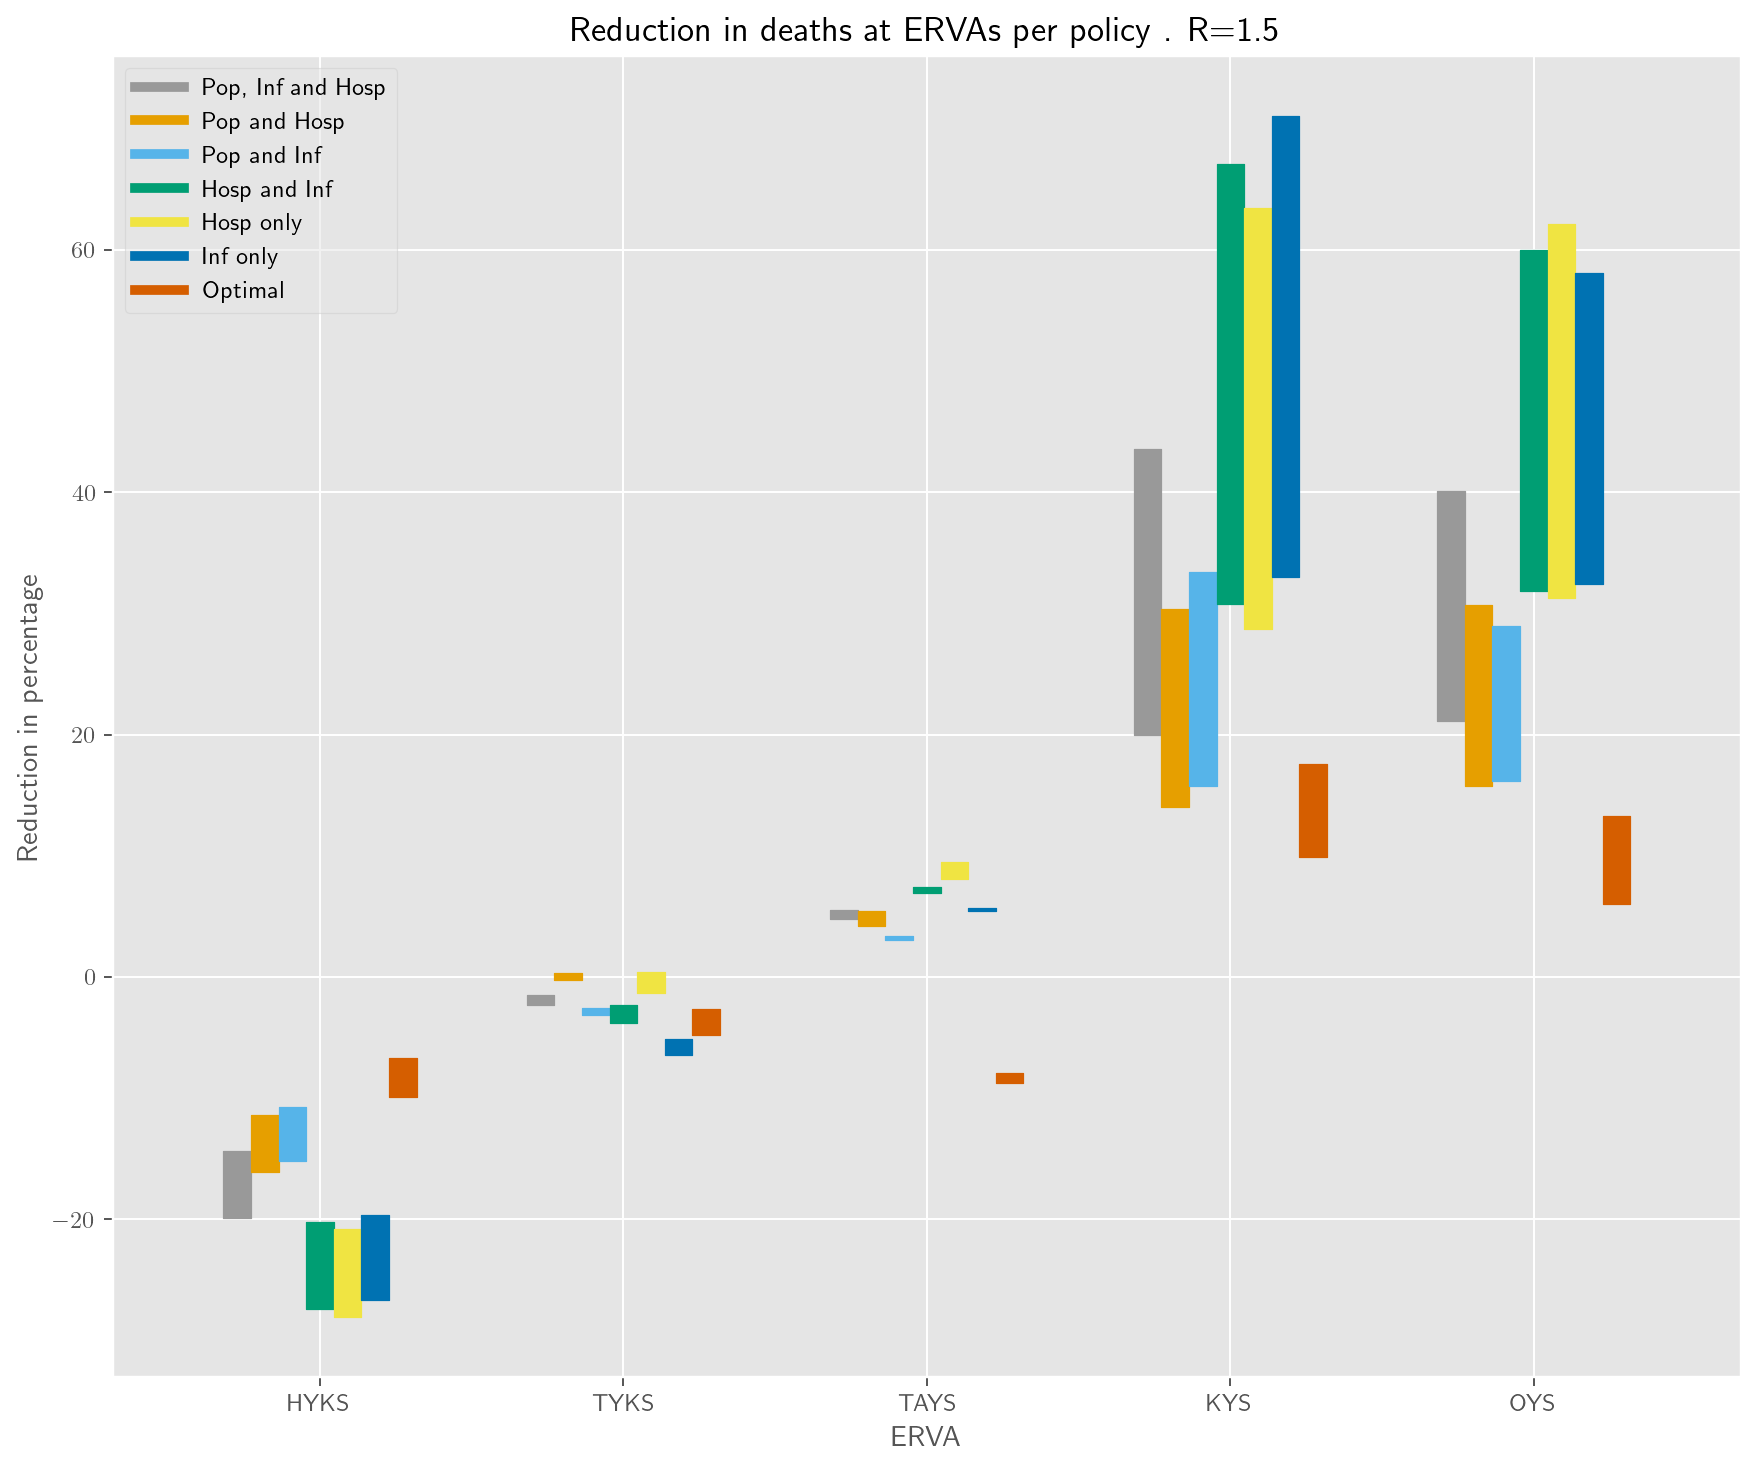

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='deaths', exp_results=exp_results, labels=ervas_labels,
                          plot='ERVA', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


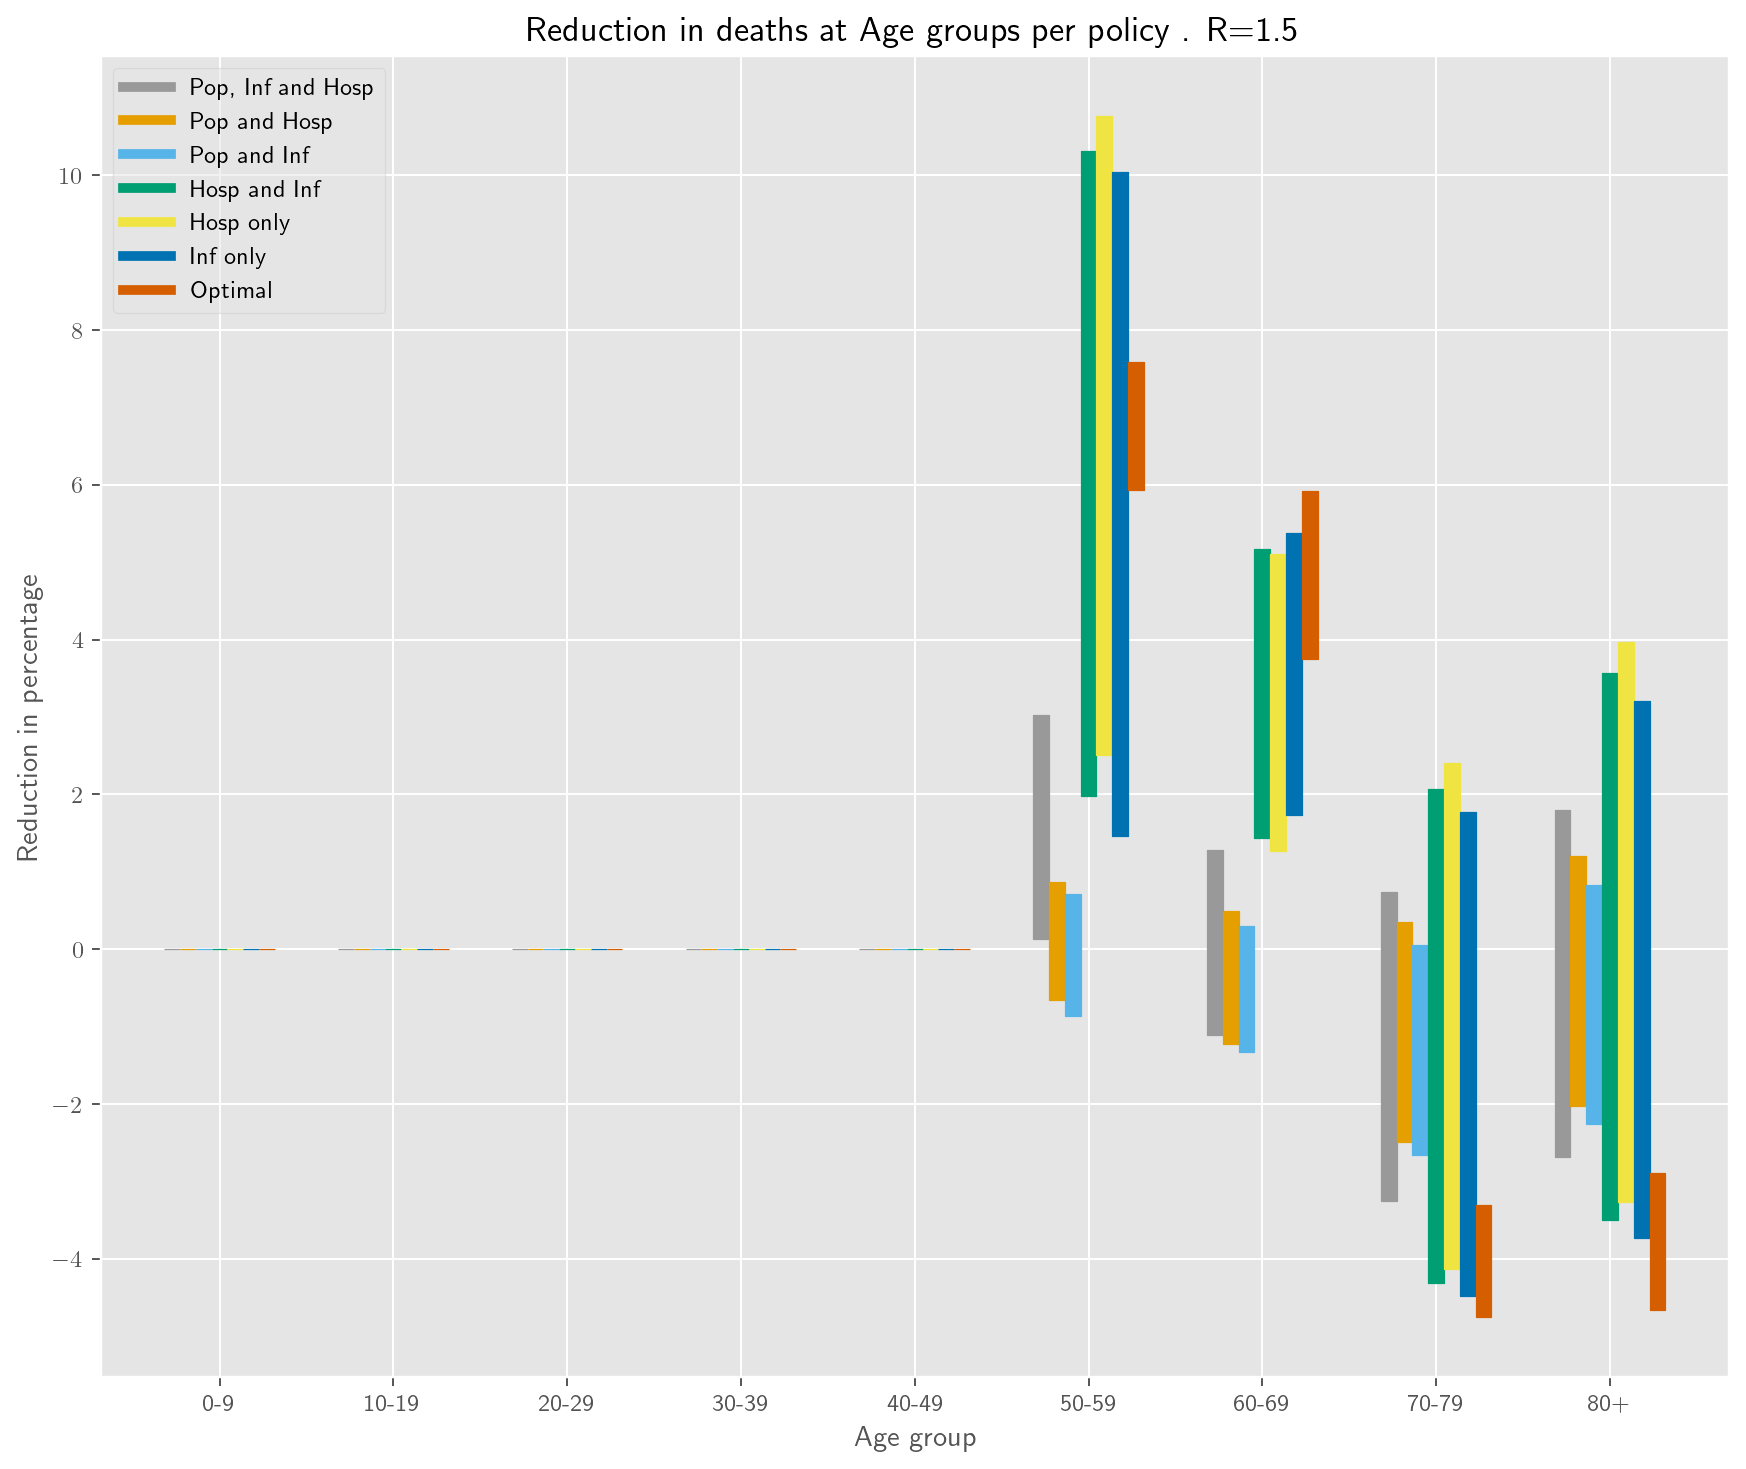

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='deaths', exp_results=exp_results, labels=age_labels,
                          plot='Age group', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

# Hospitalizations

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


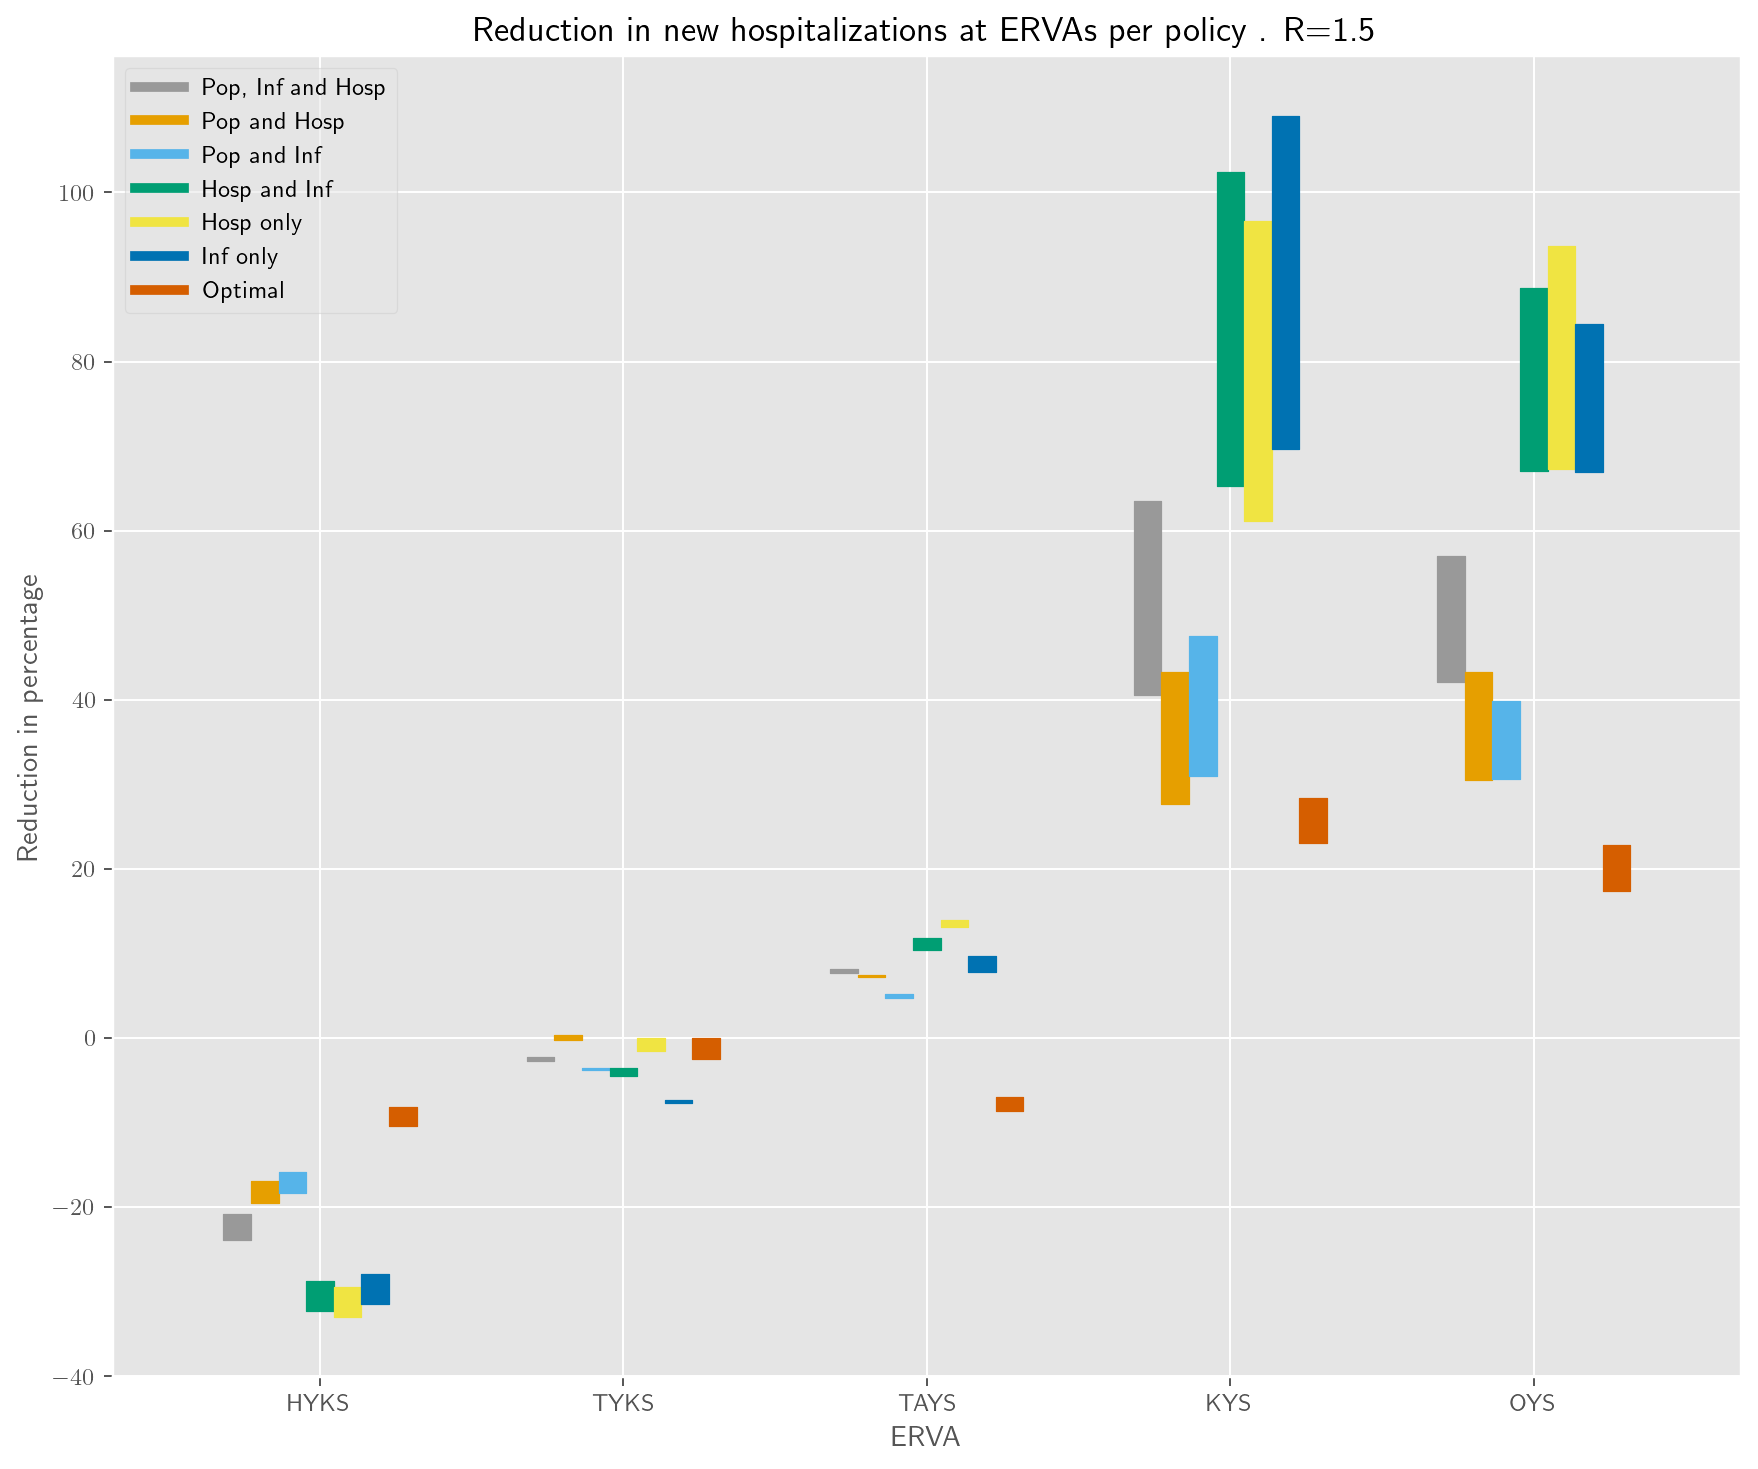

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='new hospitalizations', exp_results=exp_results, labels=ervas_labels,
                          plot='ERVA', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


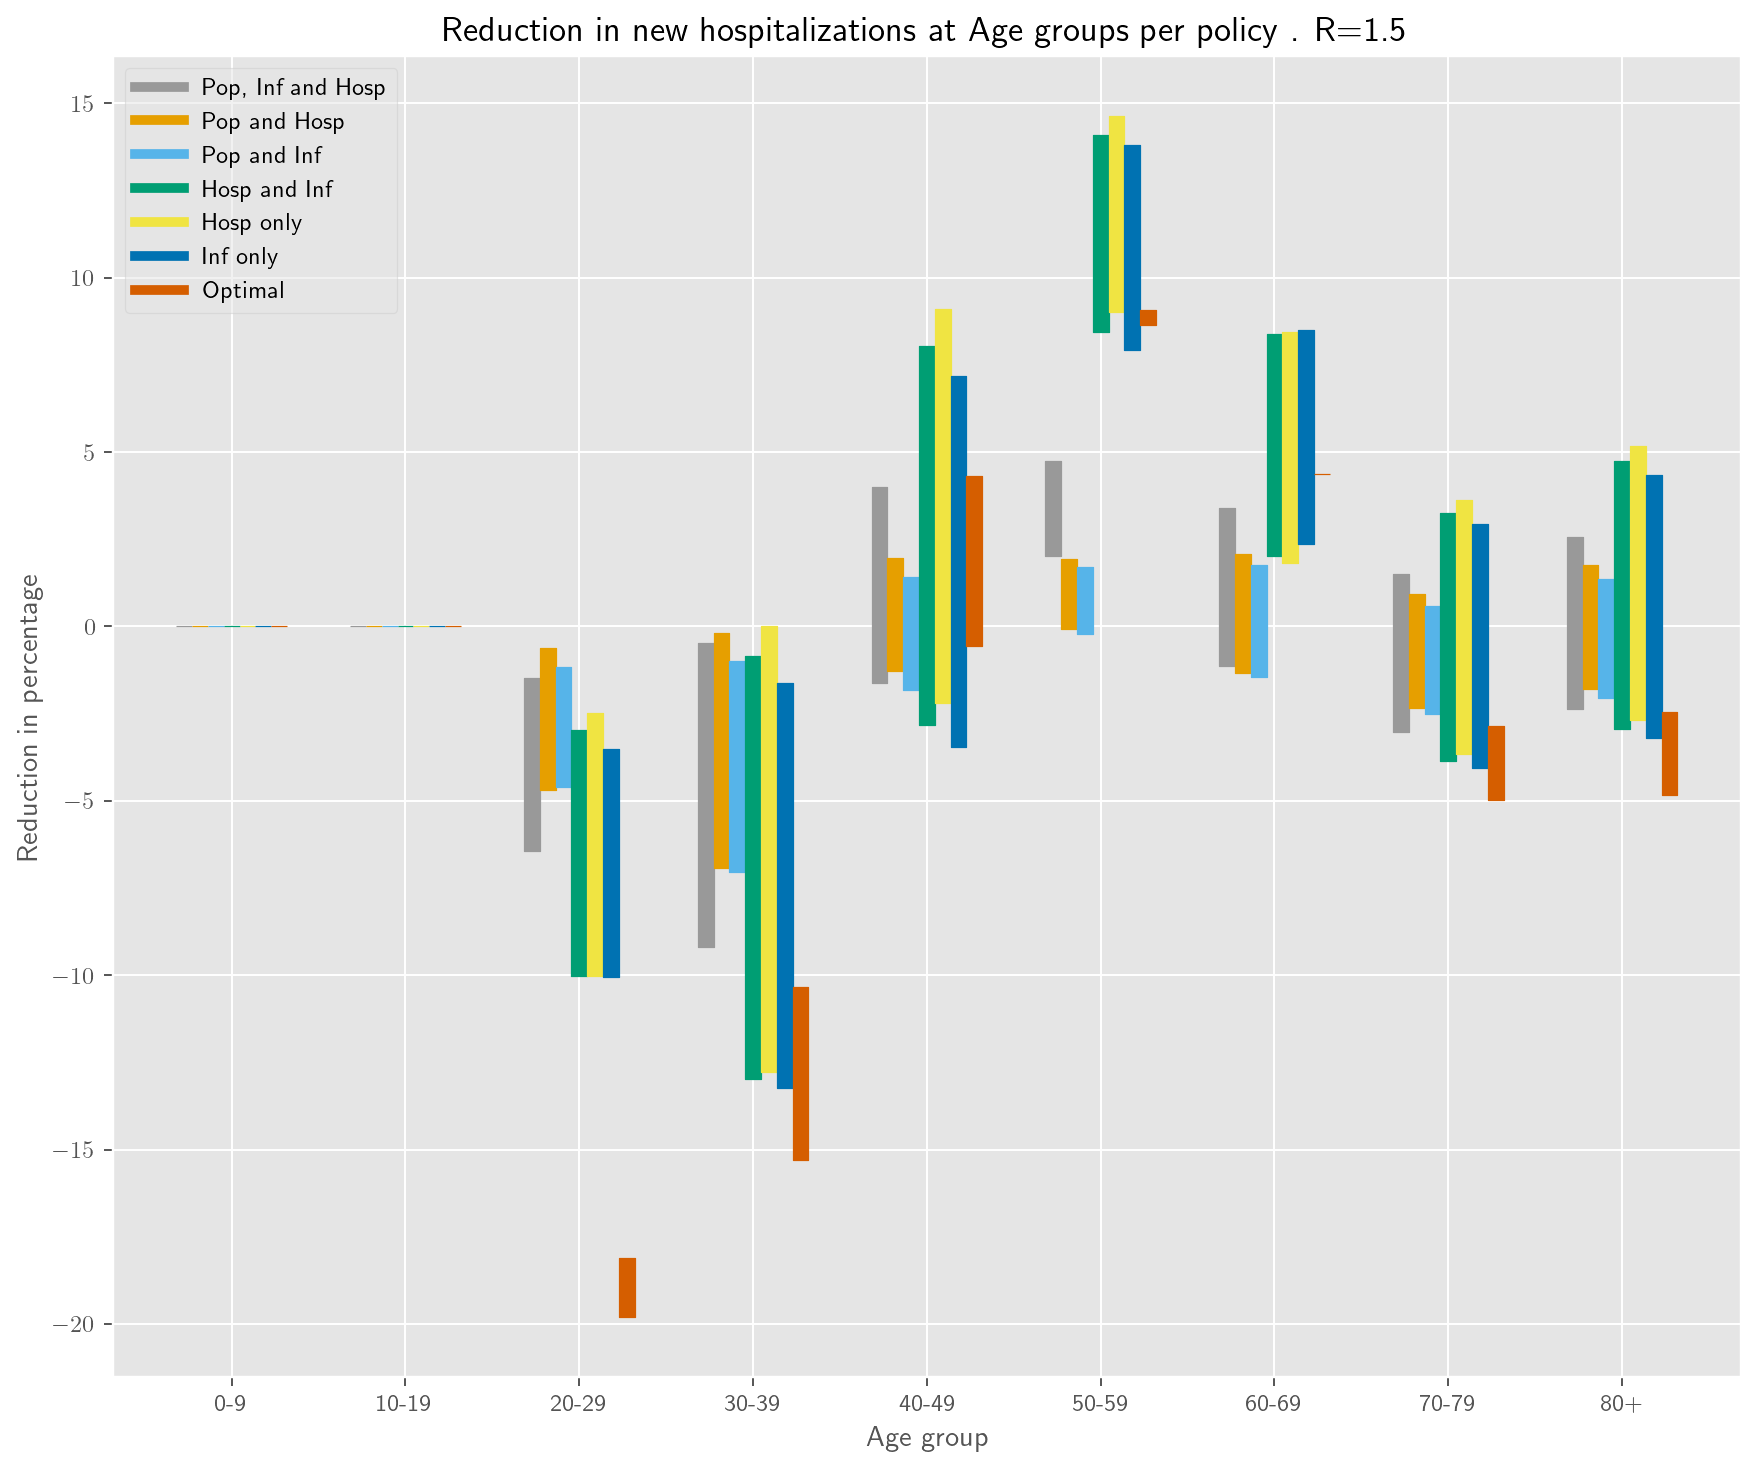

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='new hospitalizations', exp_results=exp_results, labels=age_labels,
                          plot='Age group', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

# Infections

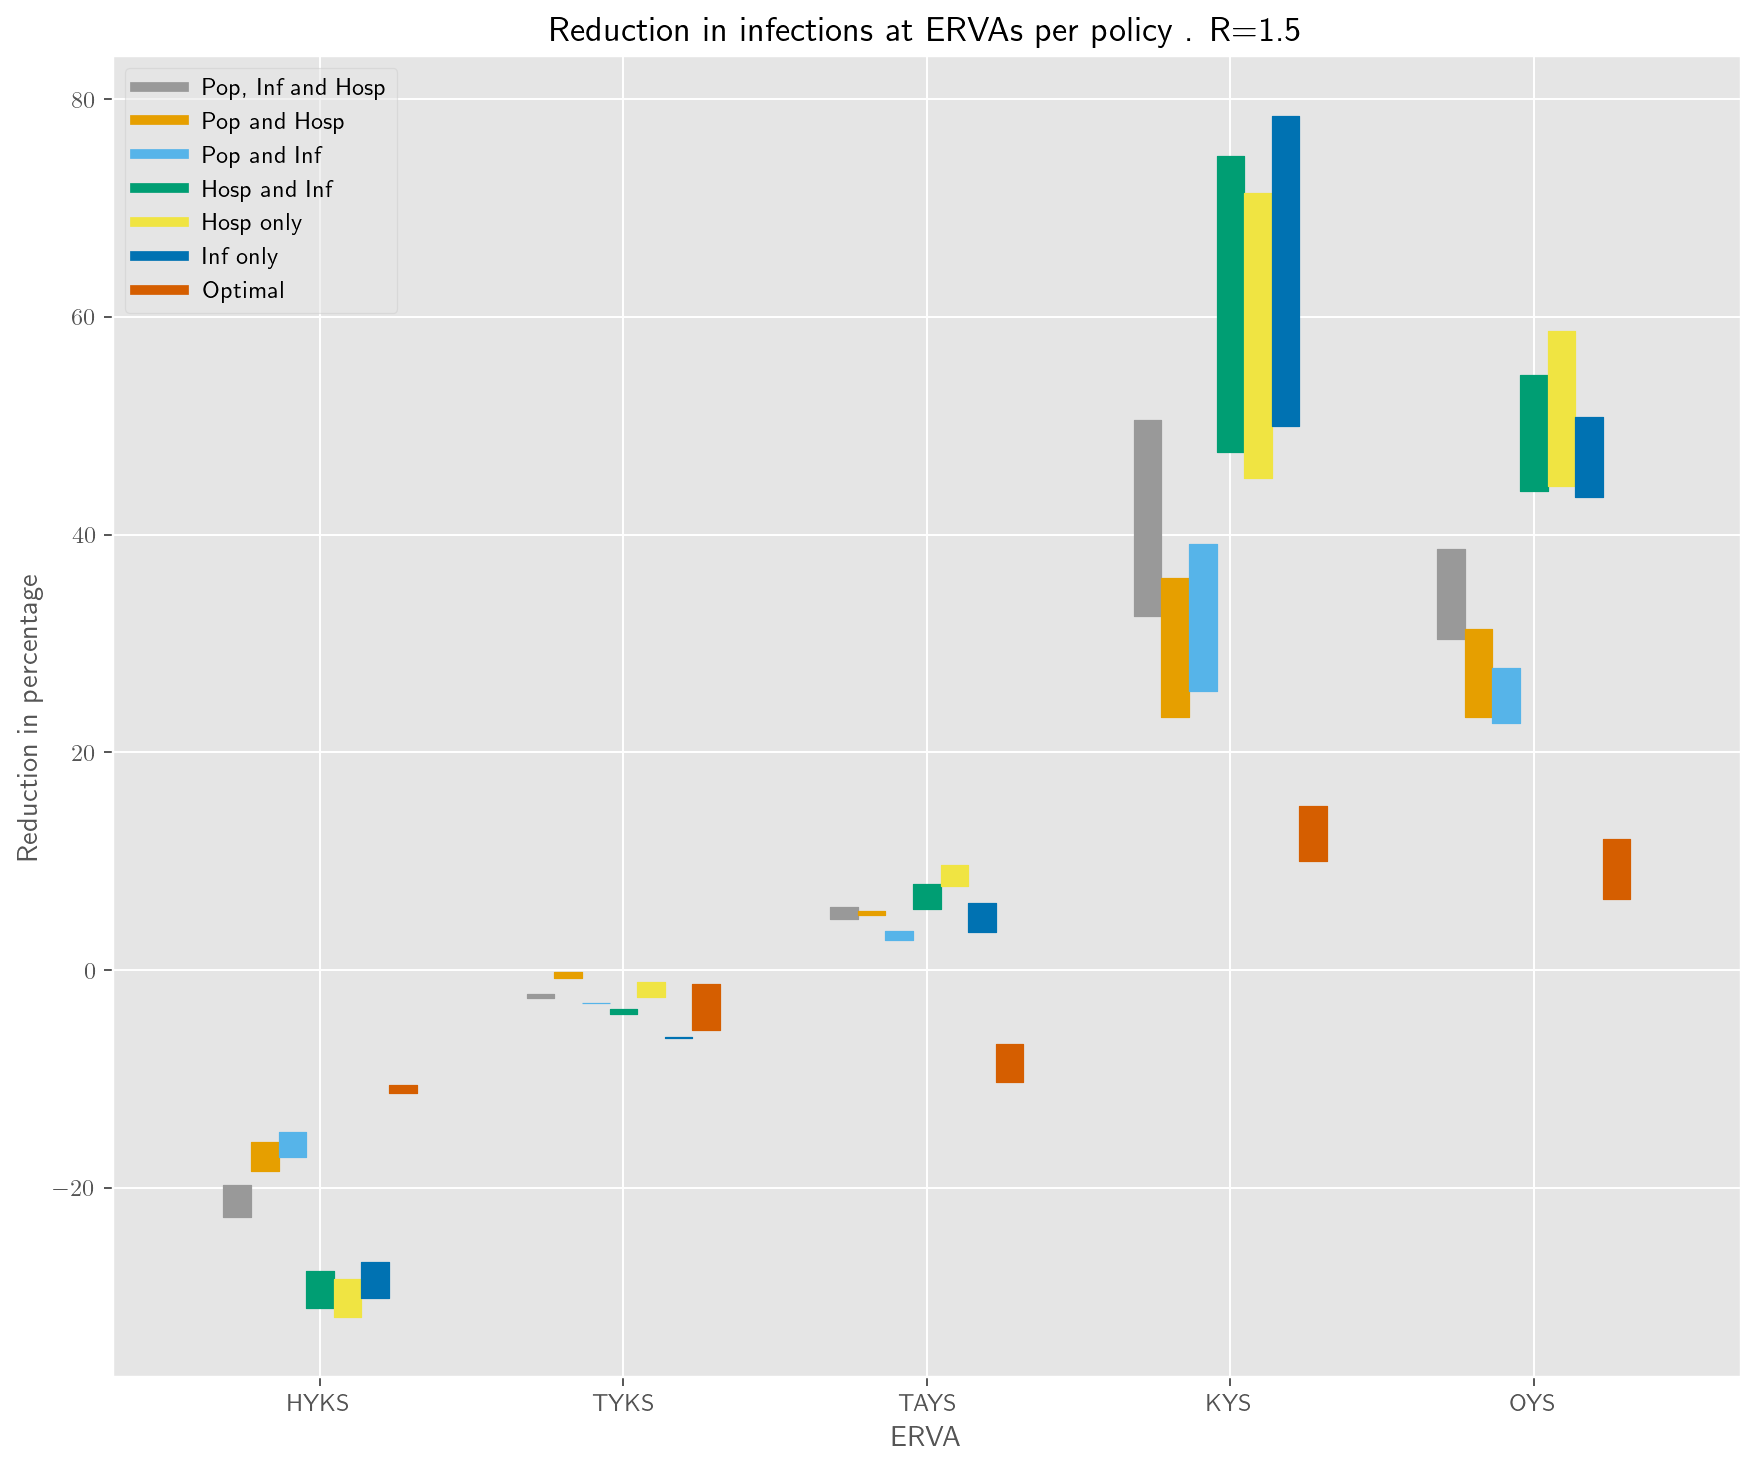

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='infections', exp_results=exp_results, labels=ervas_labels,
                          plot='ERVA', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

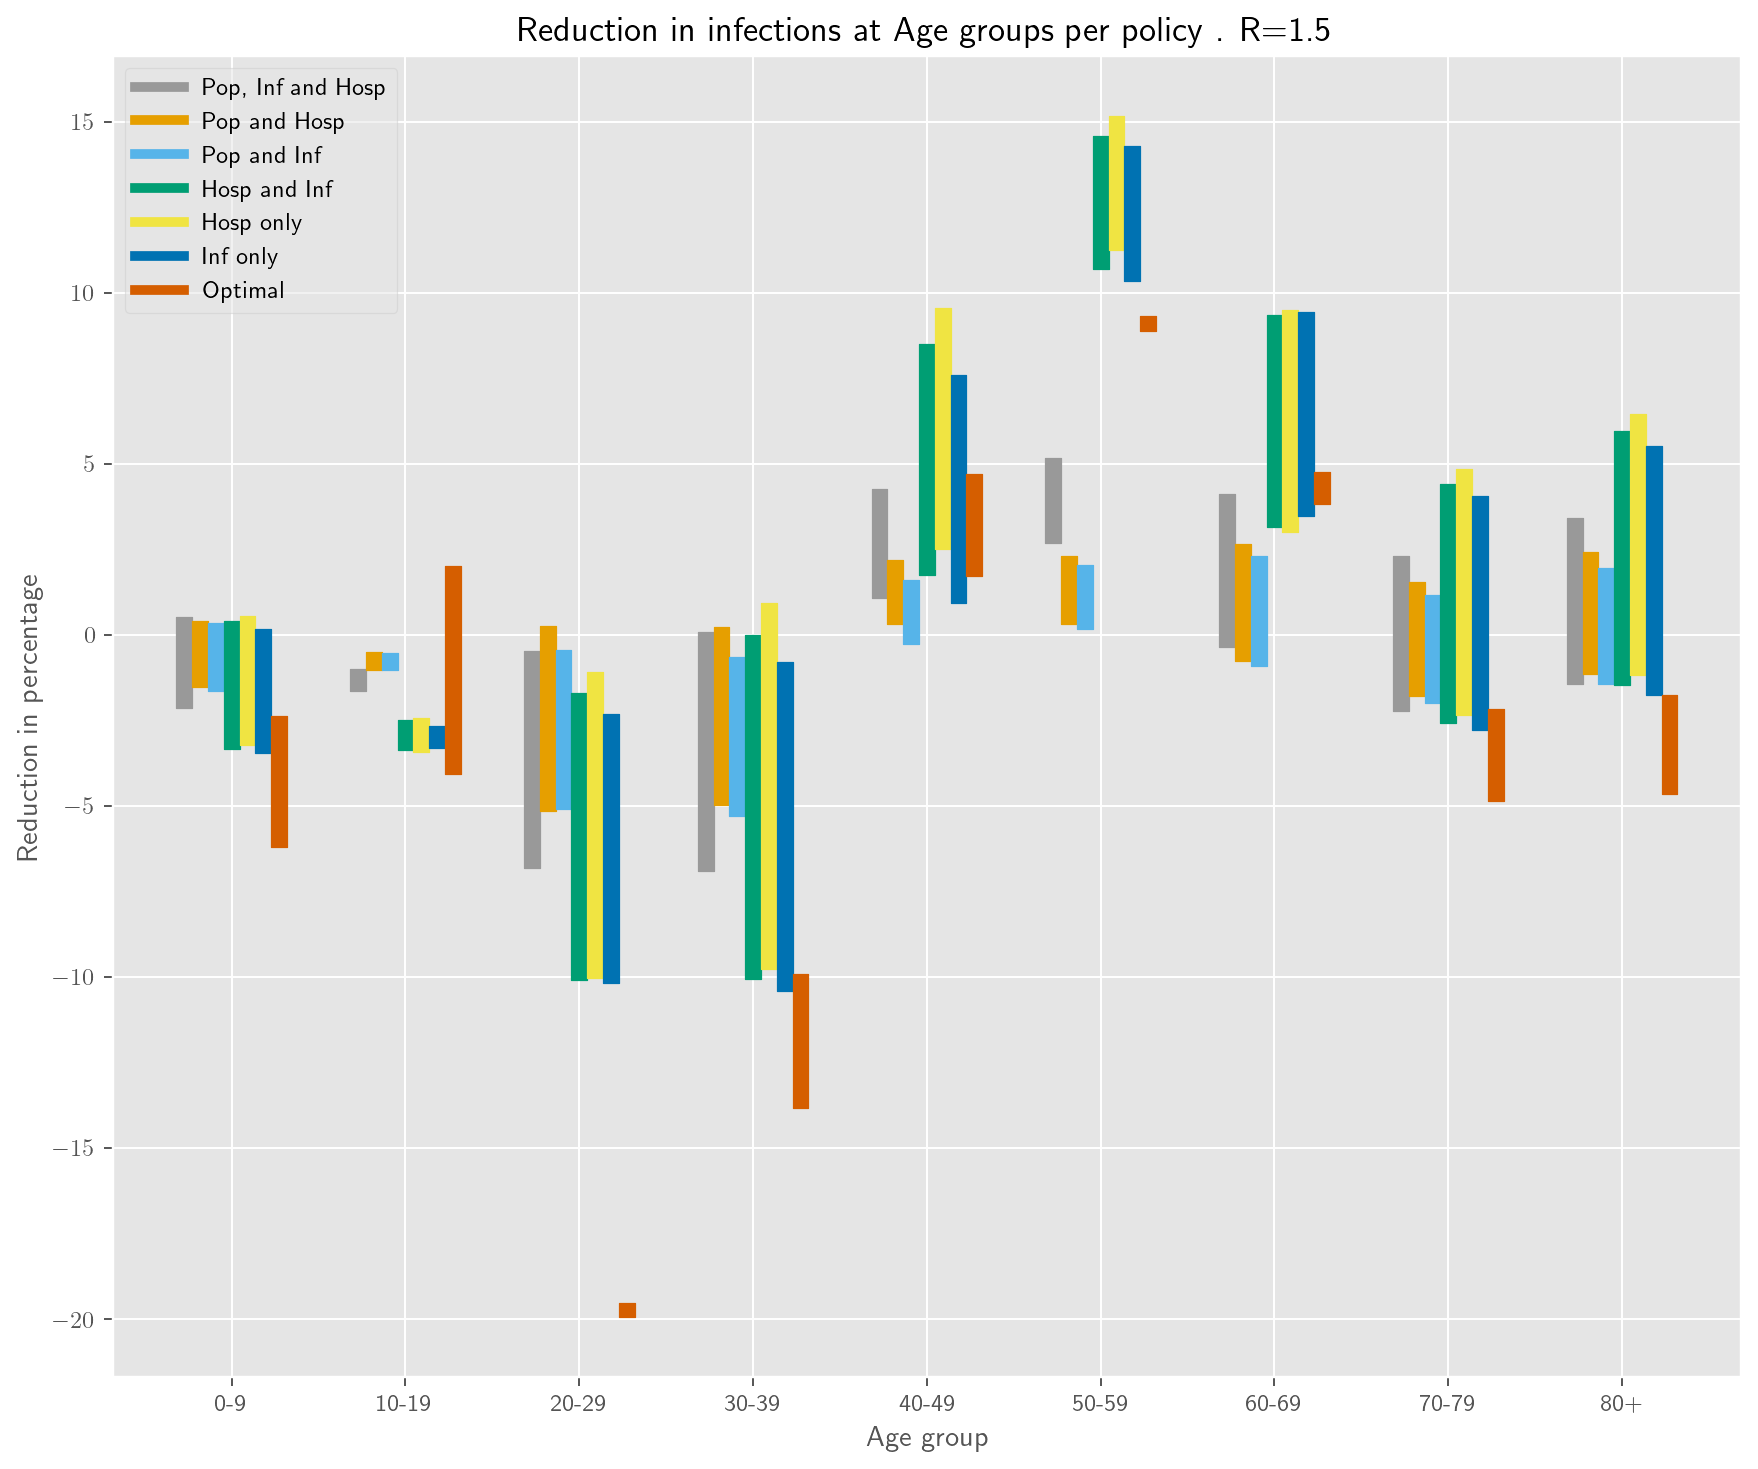

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='infections', exp_results=exp_results, labels=age_labels,
                          plot='Age group', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

# Saving figures and generating latex

In [11]:
def save_and_generate_latex(r_experiments, taus, ervas_labels, age_labels, metrics, exp_results, dpis,
                            skip_no_vacc, img_dir, t2, t1, baseline, file_format, latex_template):
    os.makedirs(img_dir, exist_ok=True)
    for r in r_experiments:
        for tau in taus:
            for metric in metrics:
                fig, axs = plt.subplots(2, 1, figsize=(11, 15))
                axs = axs.flat
                for plot, labels, ax in zip(['ERVA', 'Age group'], [ervas_labels, age_labels], axs):
                    ax = plot_bars_ages_ervas(ax=ax, r=r, tau=tau, metric=metric, plot=plot,
                                              exp_results=exp_results, labels=labels, t2=t2, t1=t1,
                                              baseline=baseline, skip_no_vacc=skip_no_vacc)
                    handles, labels = ax.get_legend_handles_labels()
                    ax.set_ylabel('')
                    ax.set_title('%ss' % (plot, ))
                fig.suptitle('Relative change in %s wrt strategy %s.\n'
                             '$R_0=%s. \\tau=%s$' % (metric, baseline, r, tau), fontsize=16)
                y_lab = 'Change in percentage (\%)'
                fig.text(0.04, 0.5, y_lab, va='center', rotation='vertical', fontsize=16)
                name = 'bars_r%s_tau%s_metric_%s' % (r, tau, metric)
                fig_name = name + '.' + file_format 
                fig_path = os.path.join(img_dir, fig_name)
                fig.savefig(fig_path, format=file_format, dpi=dpis, bbox_inches='tight')
                
                latext_text = latex_template.format(fig_name=fig_name,
                                                    metric=metric,
                                                    baseline=baseline,
                                                    name=name,
                                                    r=r,
                                                    tau=tau)
                print(latext_text)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide



    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r0.75_tau0.5_metric_deaths.pdf}
      \caption{Relative change in deaths for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative deaths between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = 0.75$ and the mobility value $\tau = 0.5$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}
      \label{fig:bars_r0.75_tau0.5_metric_deaths}
    \end{figure}



/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide



    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r0.75_tau0.5_metric_new hospitalizations.pdf}
      \caption{Relative change in new hospitalizations for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative new hospitalizations between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = 0.75$ and the mobility value $\tau = 0.5$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}
      \label{fig:bars_r0.75_tau0.5_metric_new hospitalizations}
    \end{figure}


    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r0.75_tau0.5_metric_infections.pdf}
      \caption{Relative change in infections for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in 

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide



    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r1.5_tau0.5_metric_deaths.pdf}
      \caption{Relative change in deaths for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative deaths between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = 1.5$ and the mobility value $\tau = 0.5$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}
      \label{fig:bars_r1.5_tau0.5_metric_deaths}
    \end{figure}


    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r1.5_tau0.5_metric_new hospitalizations.pdf}
      \caption{Relative change in new hospitalizations for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative new hospitalizations between 

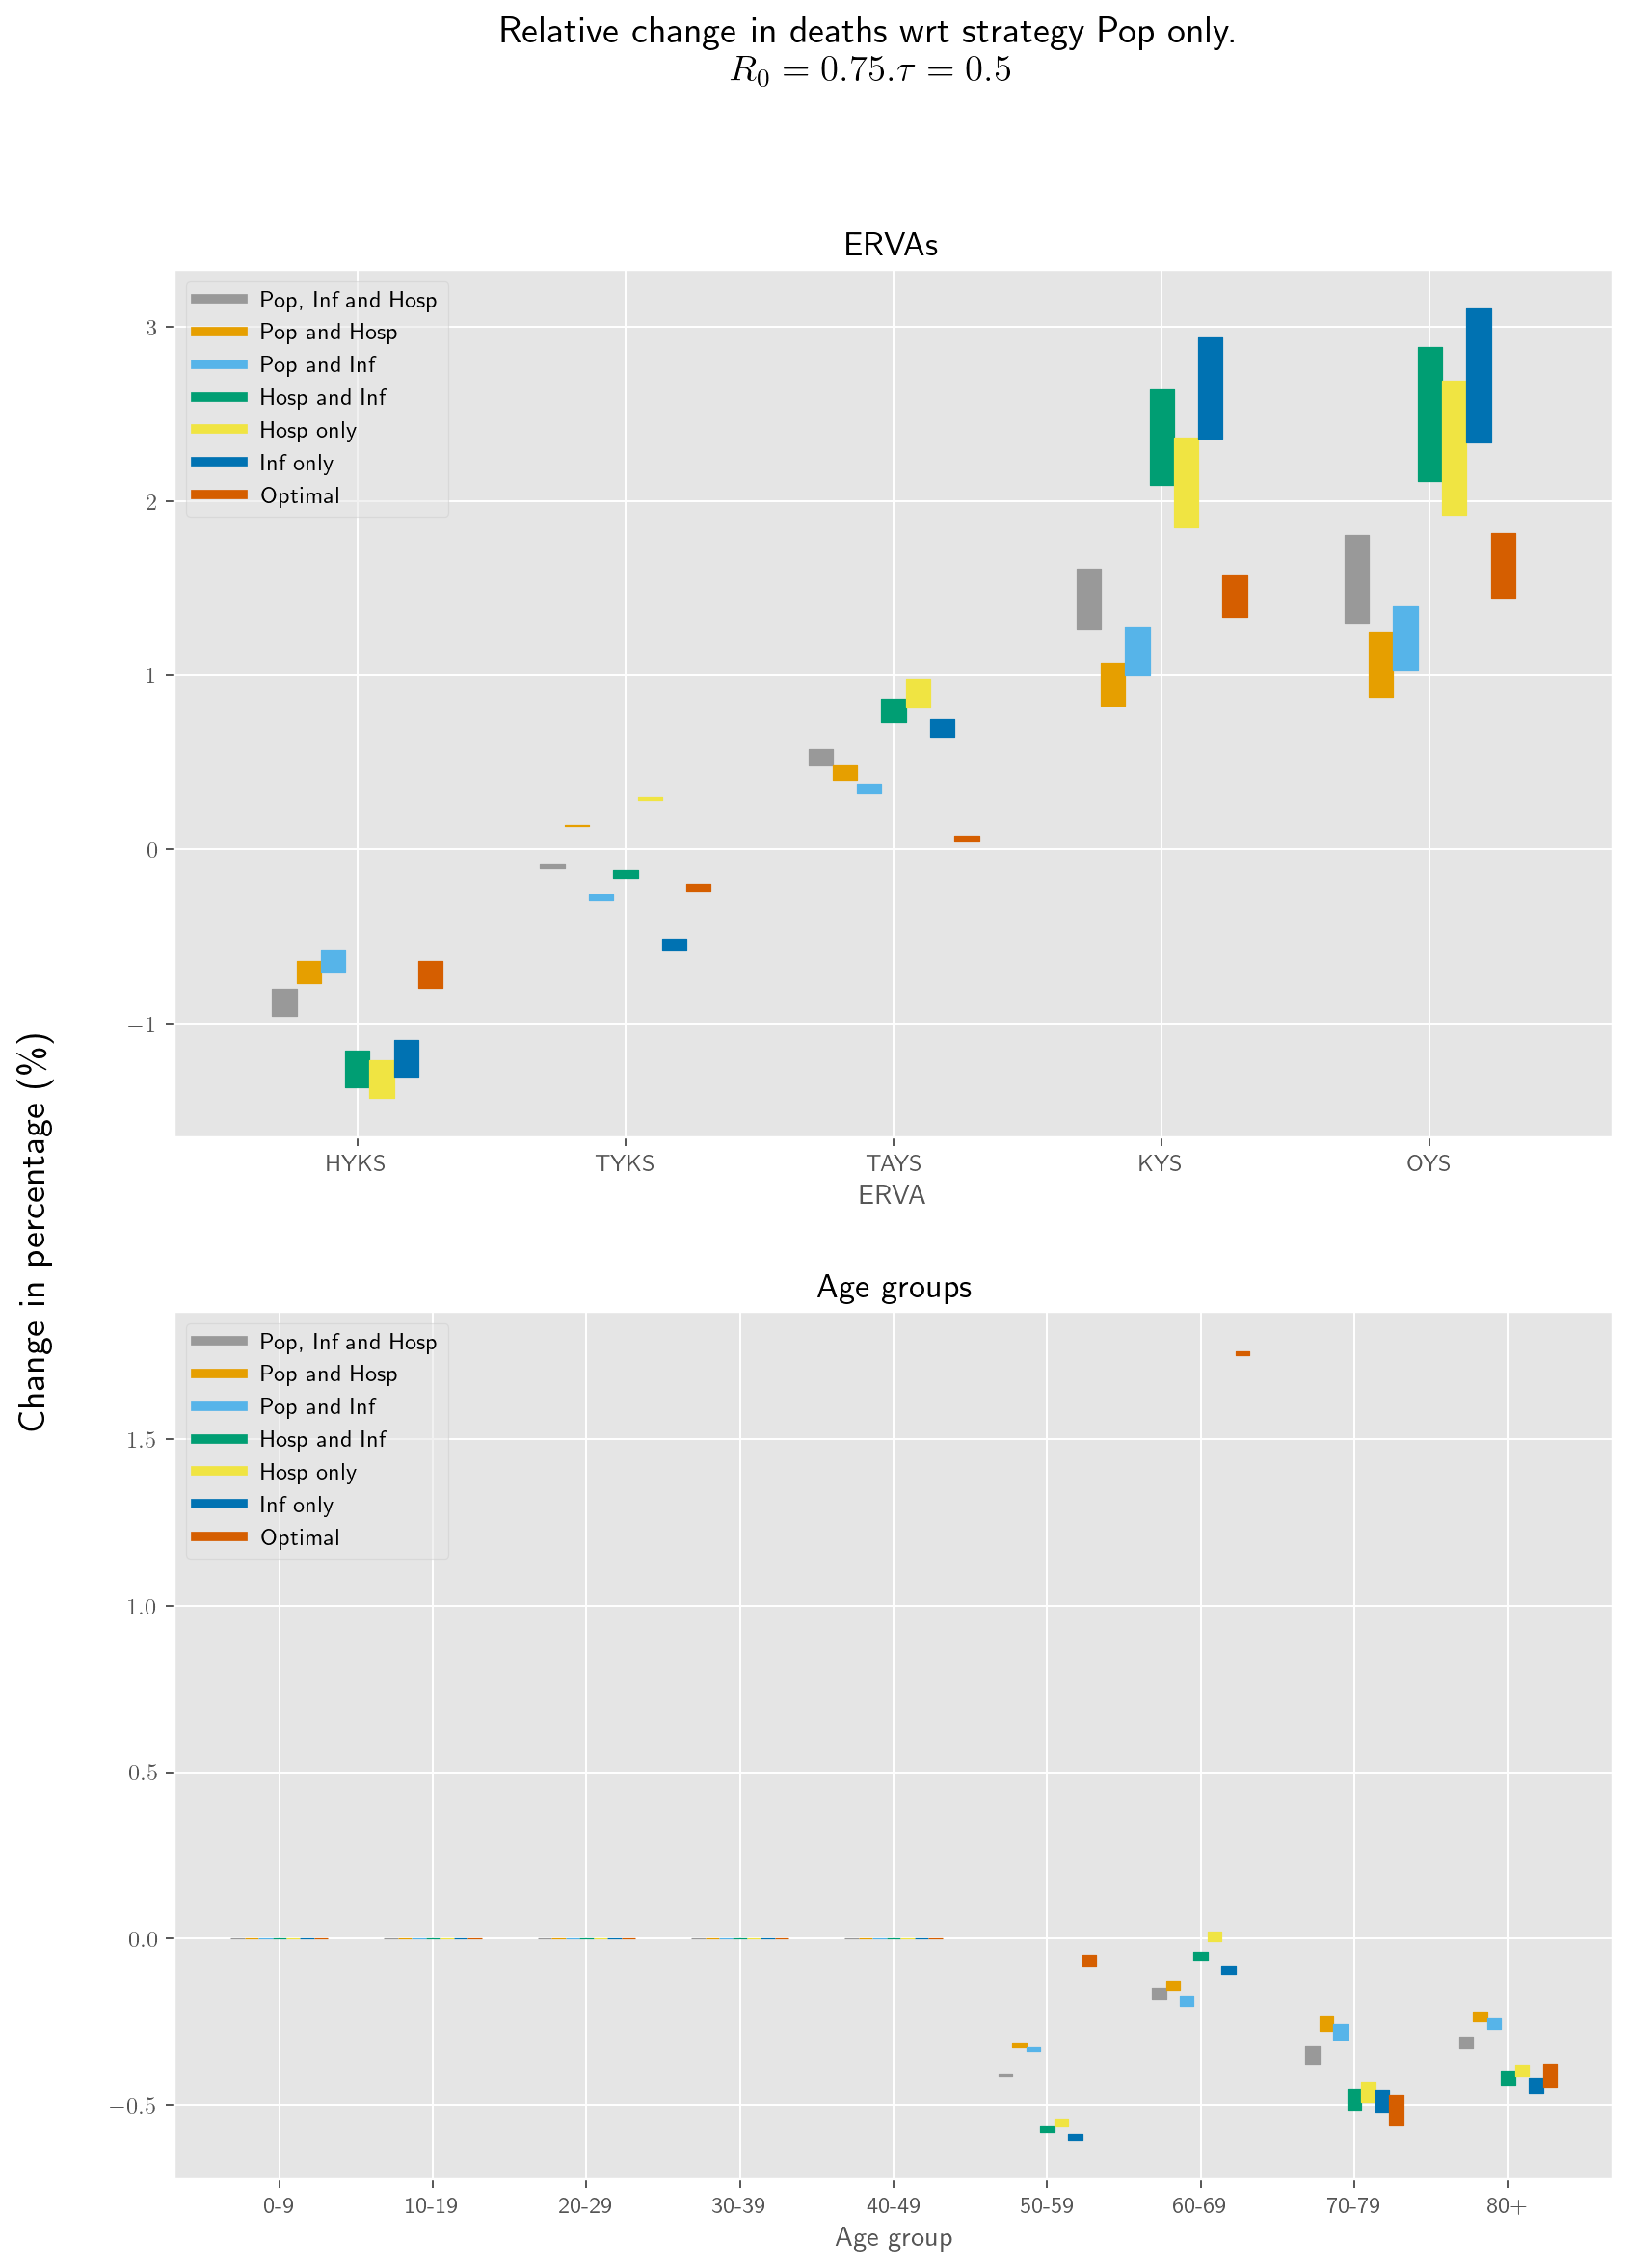

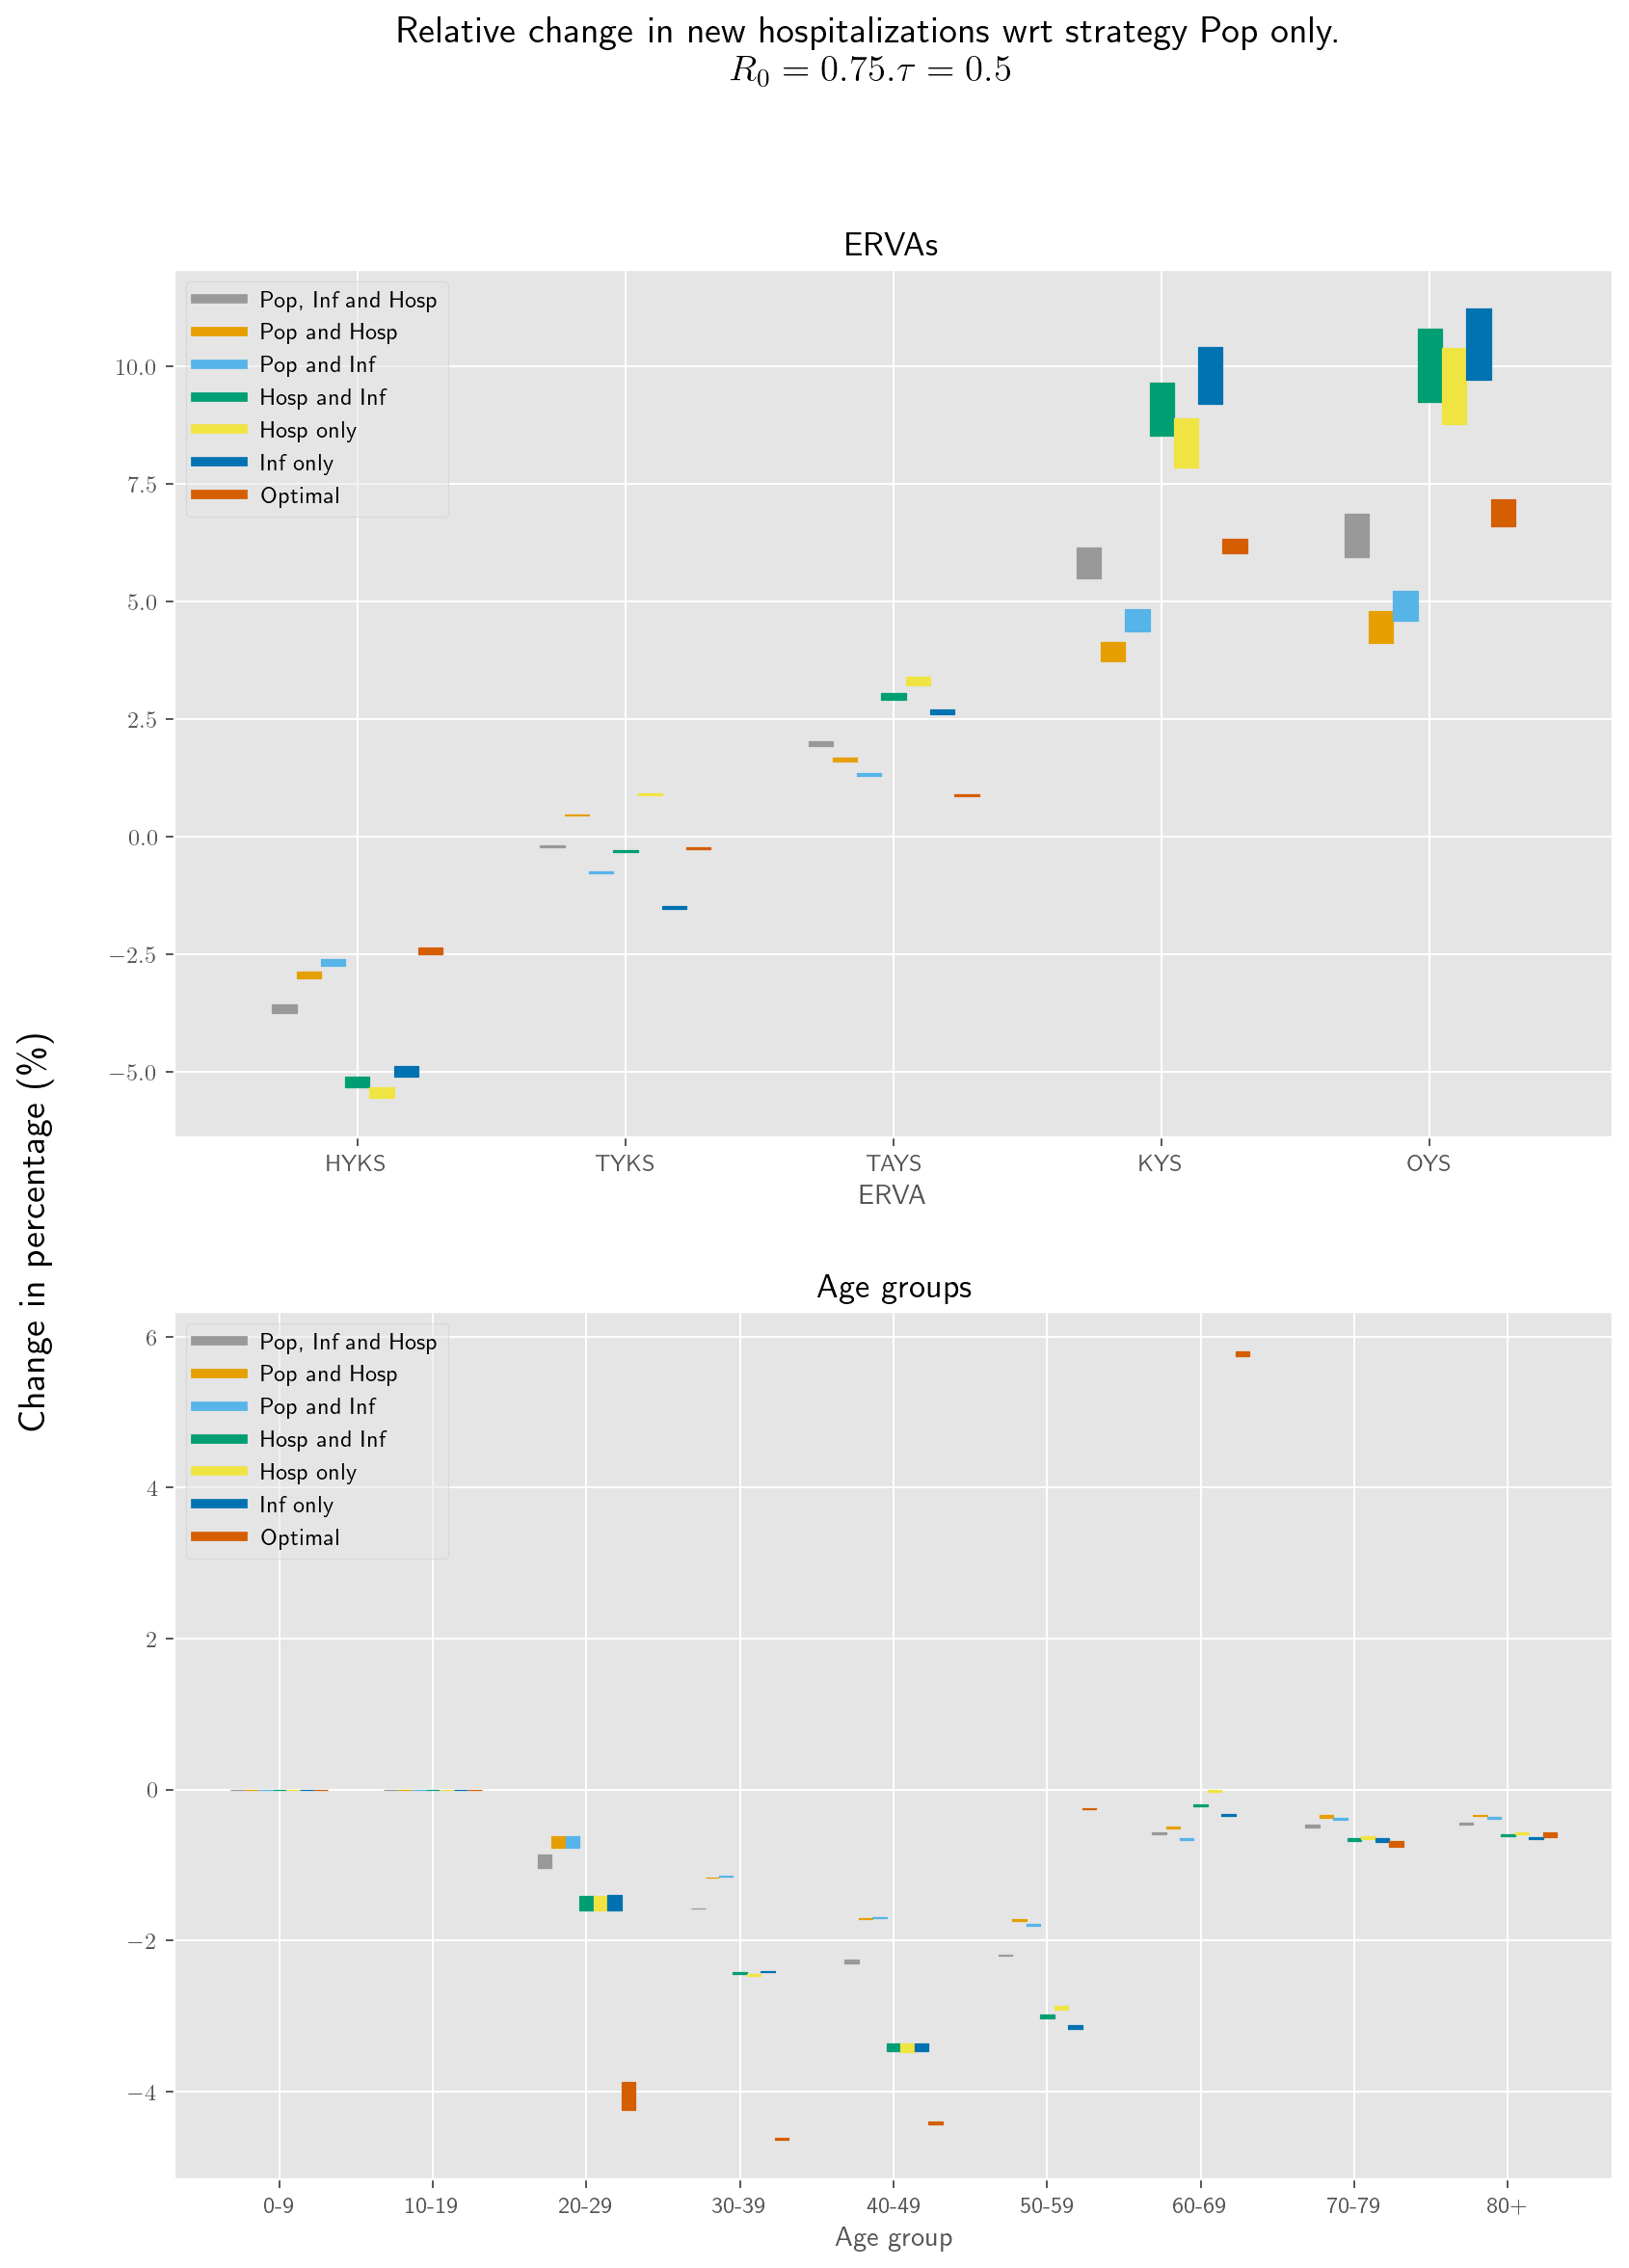

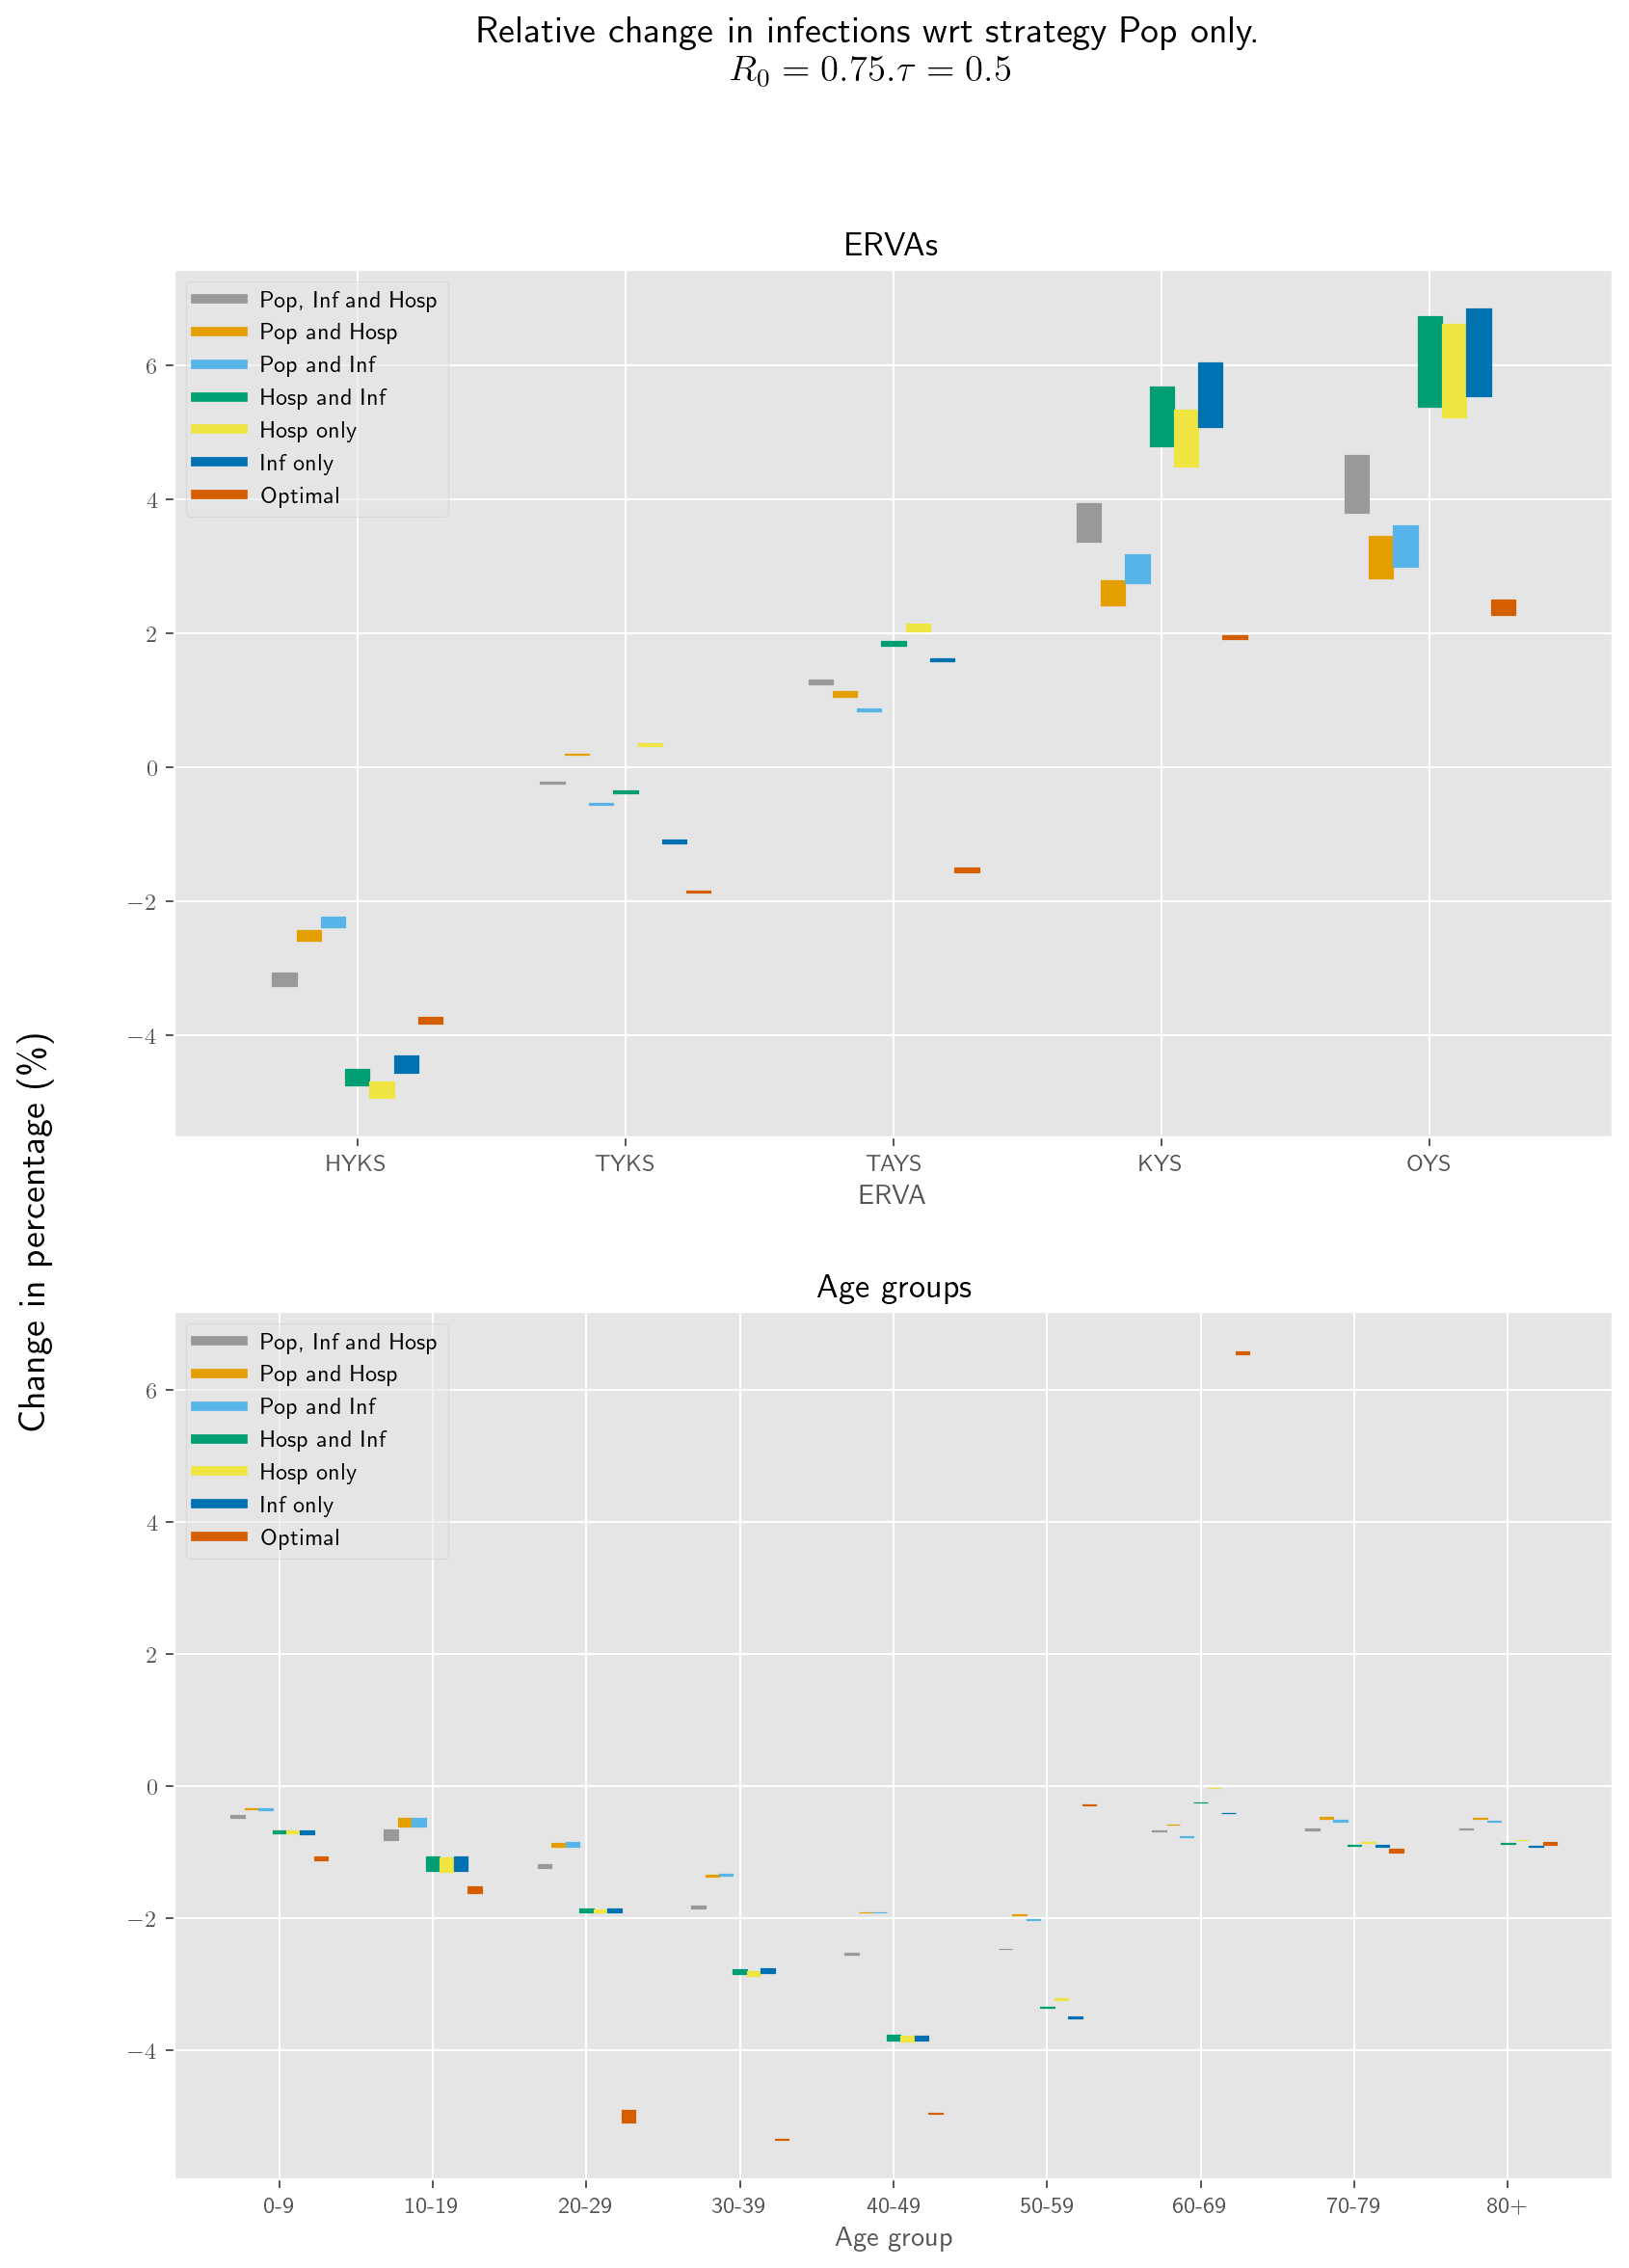

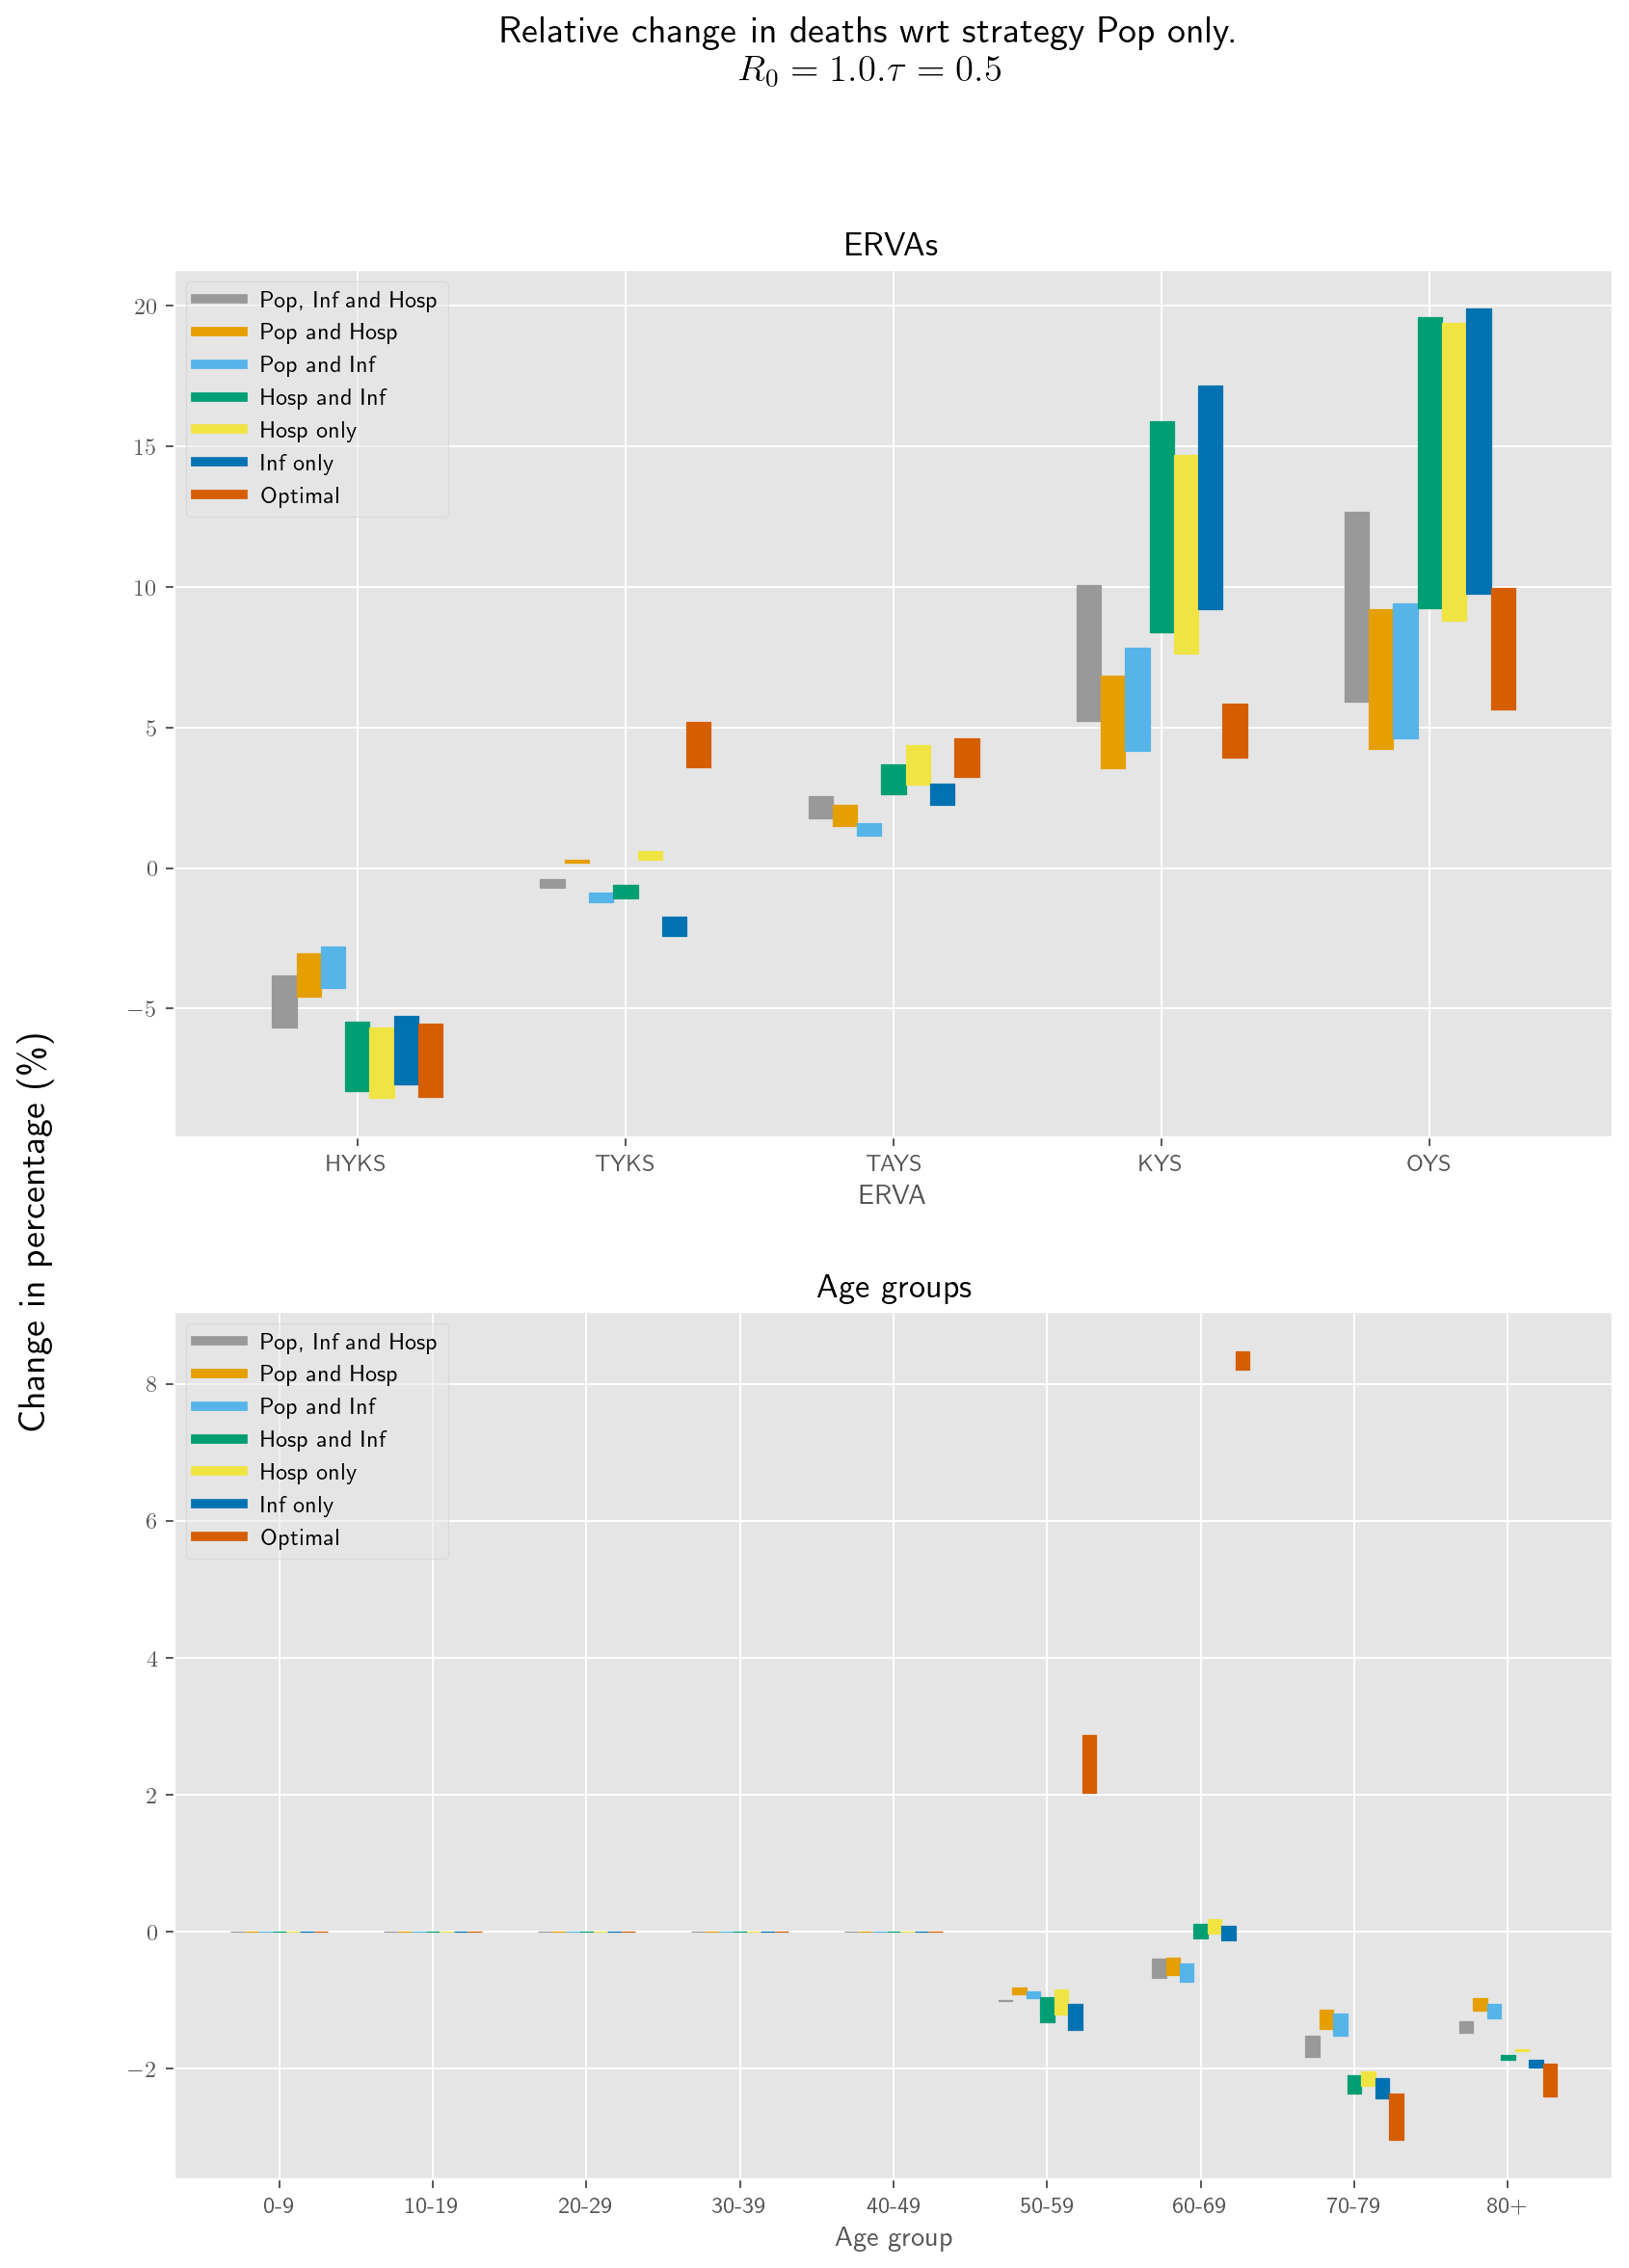

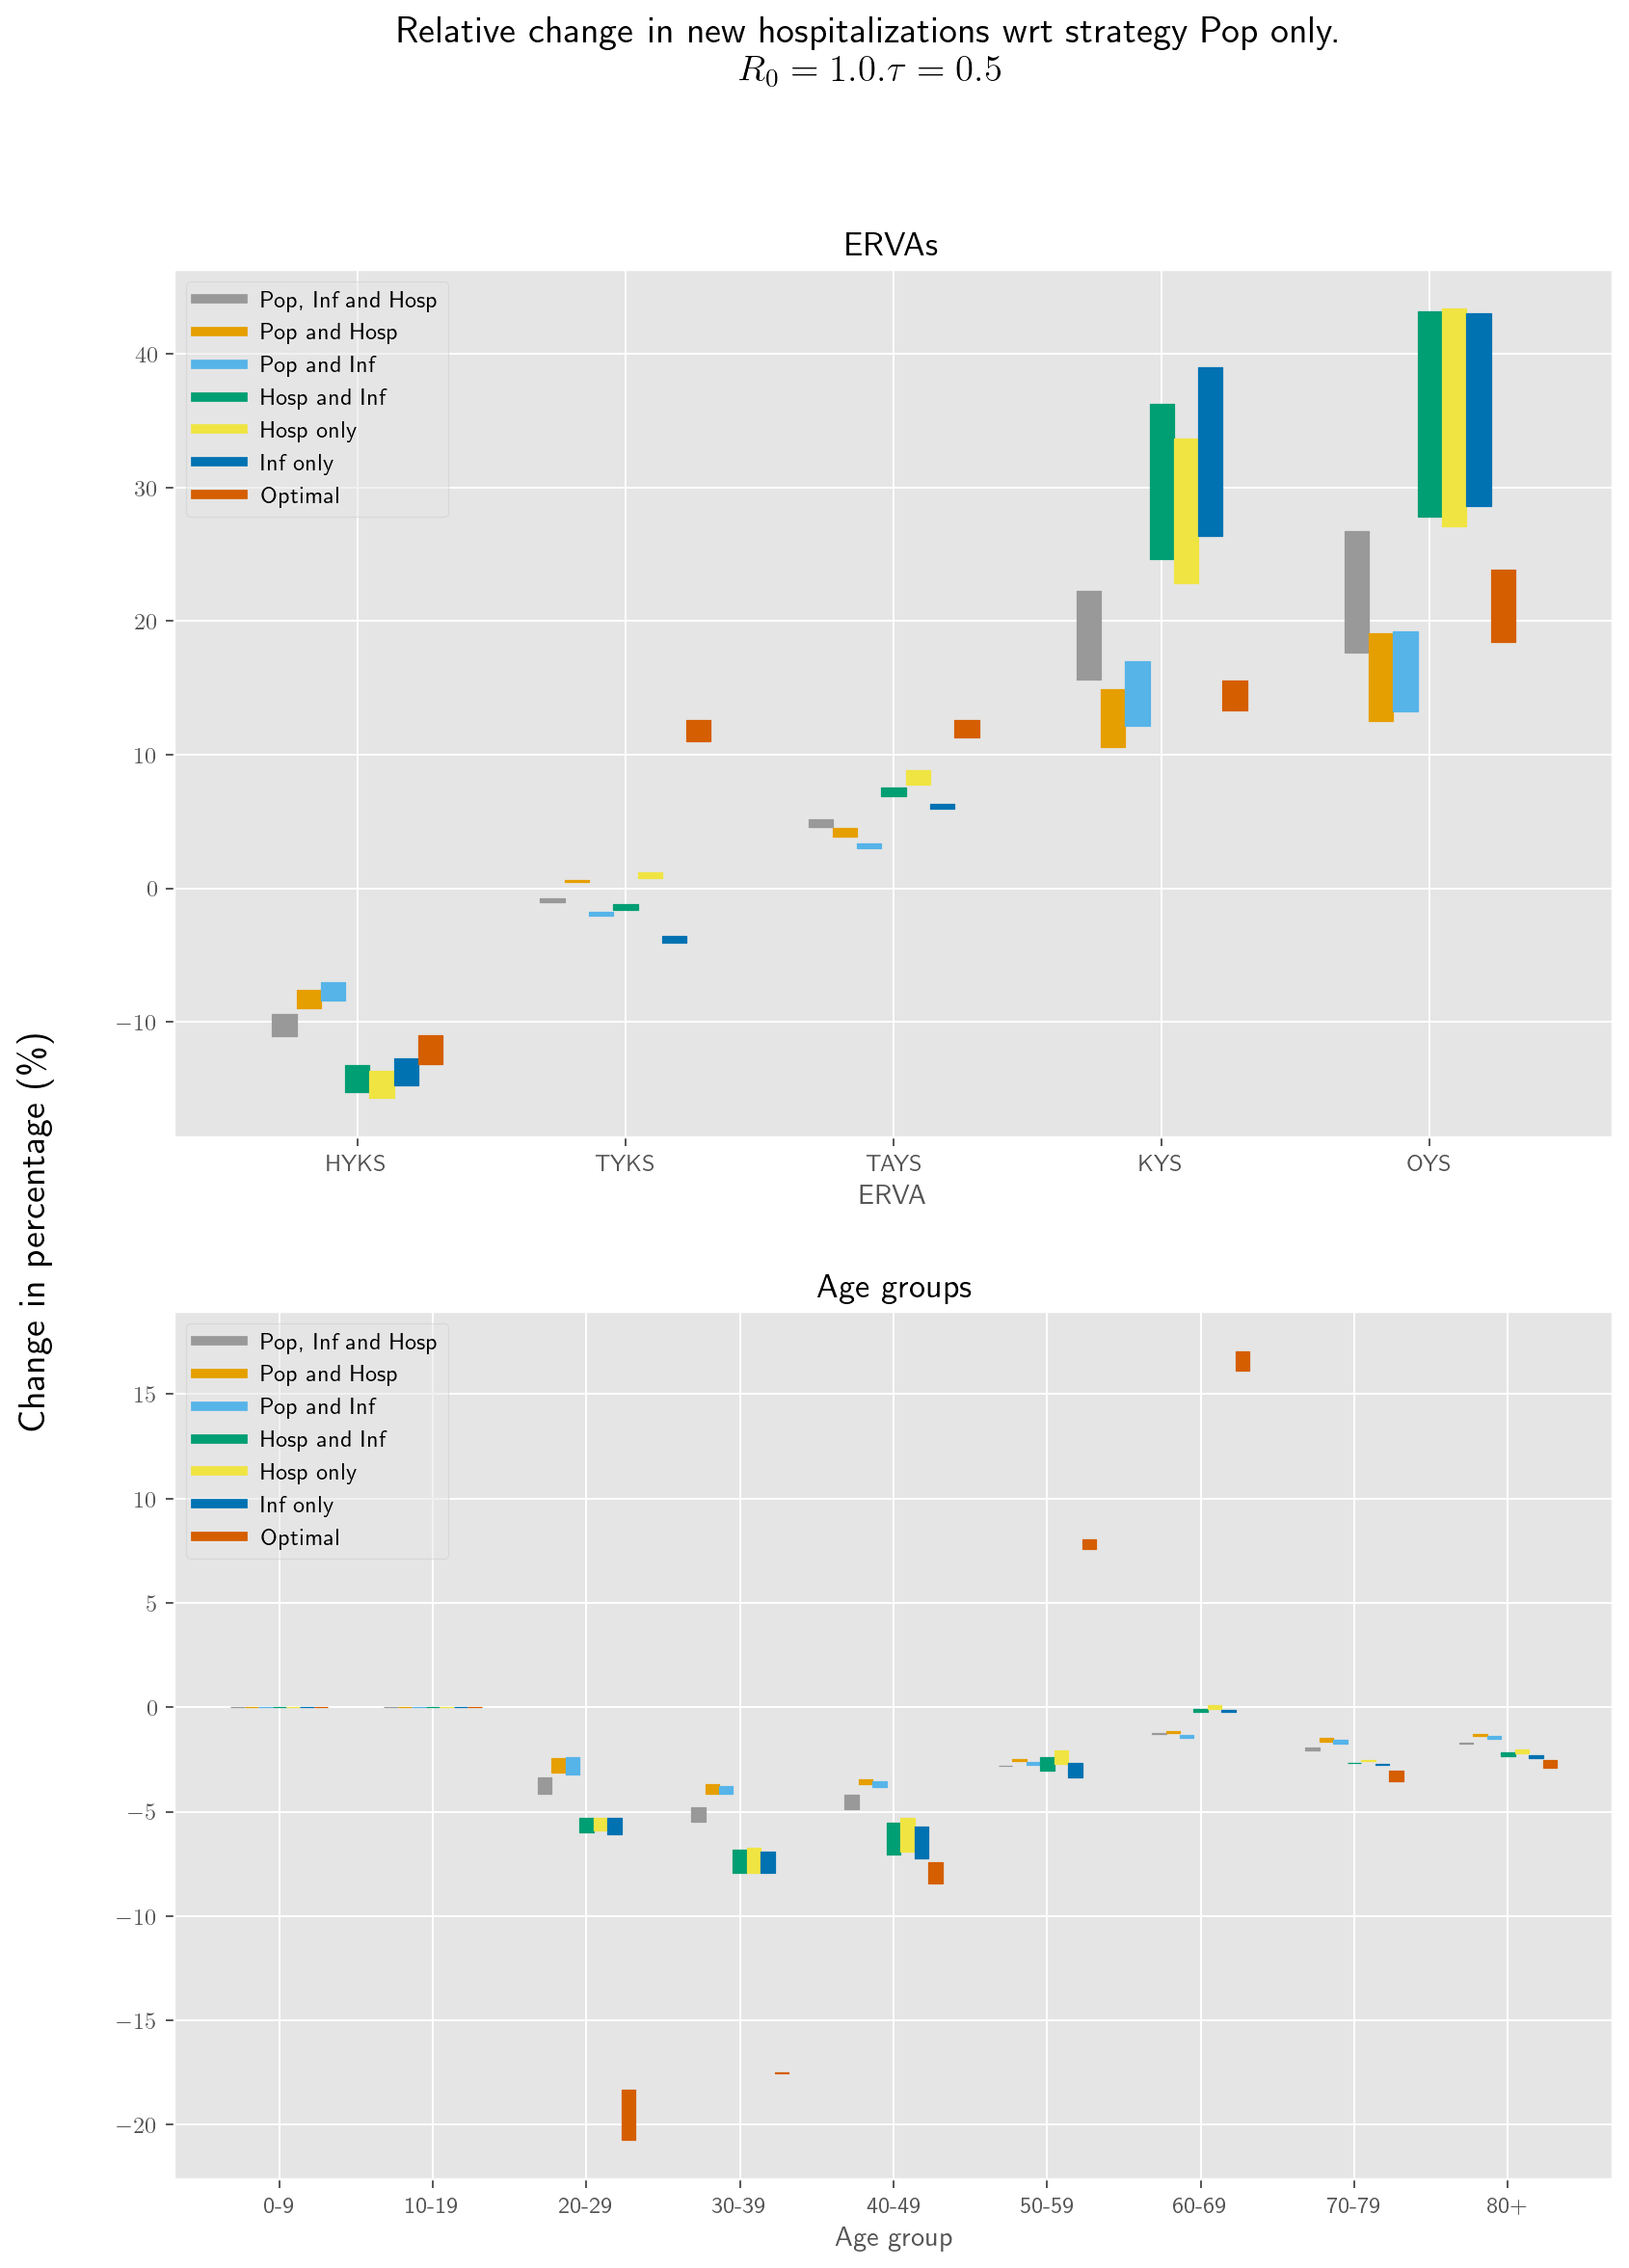

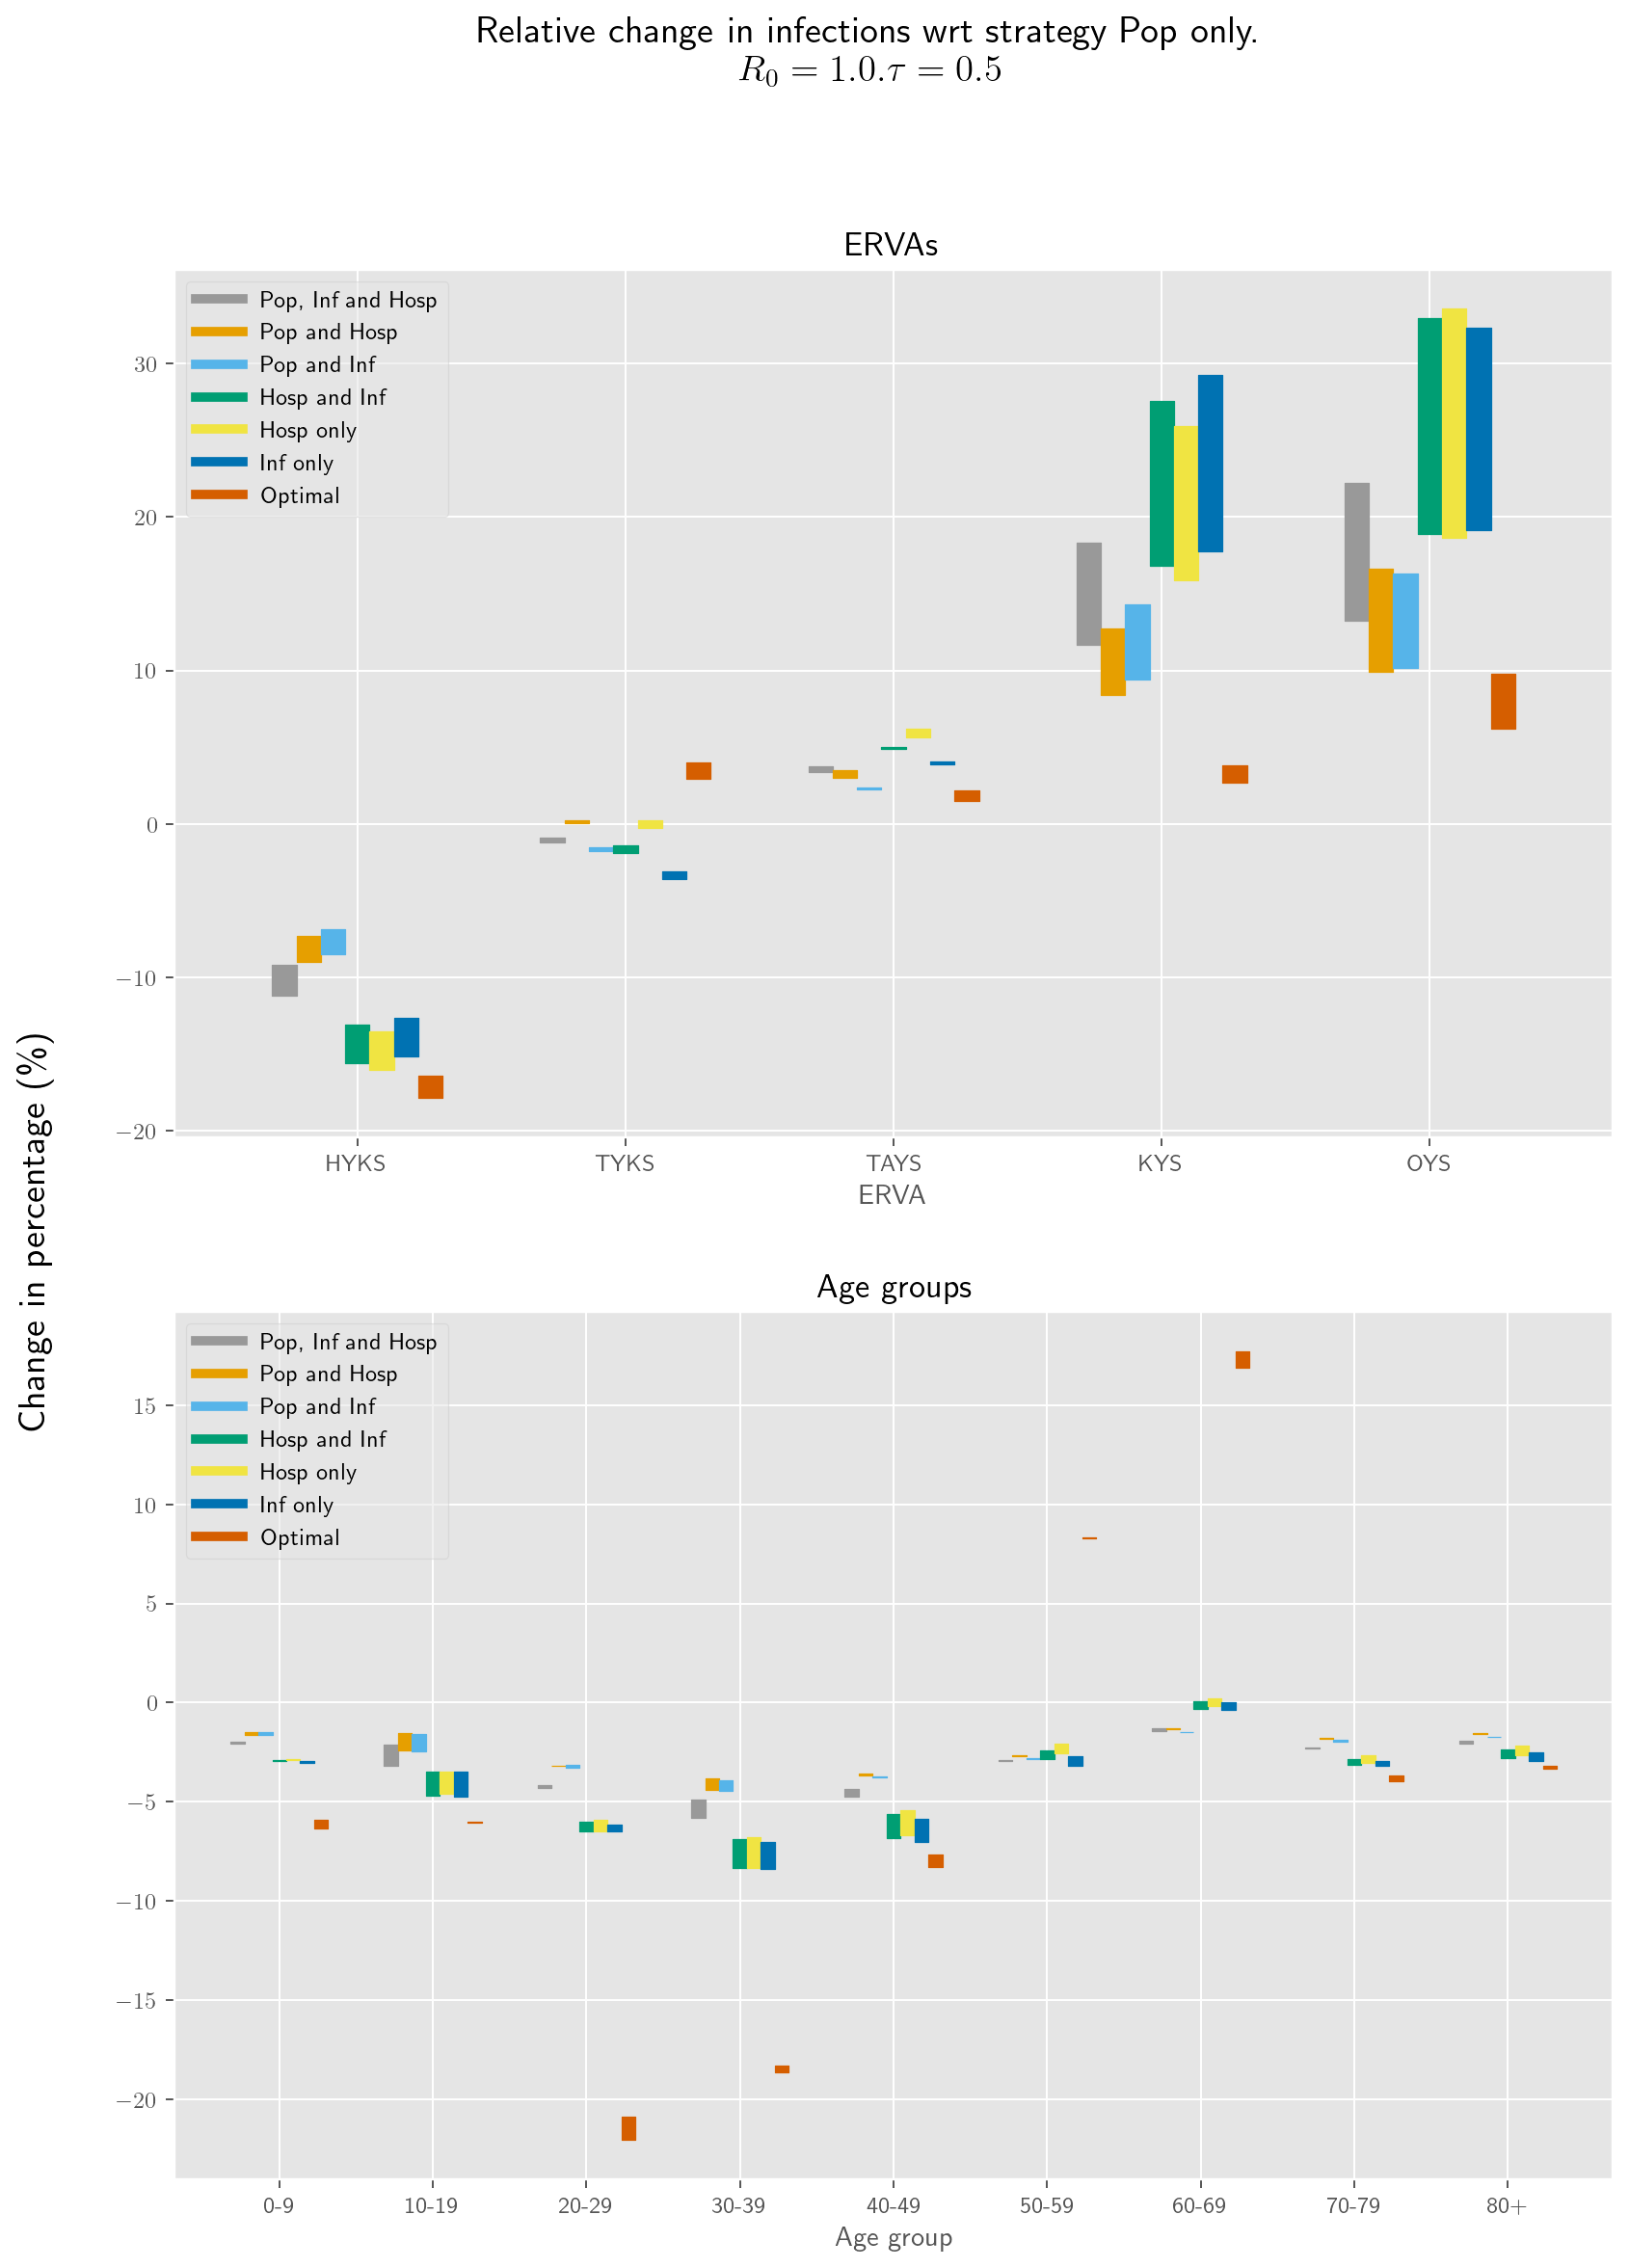

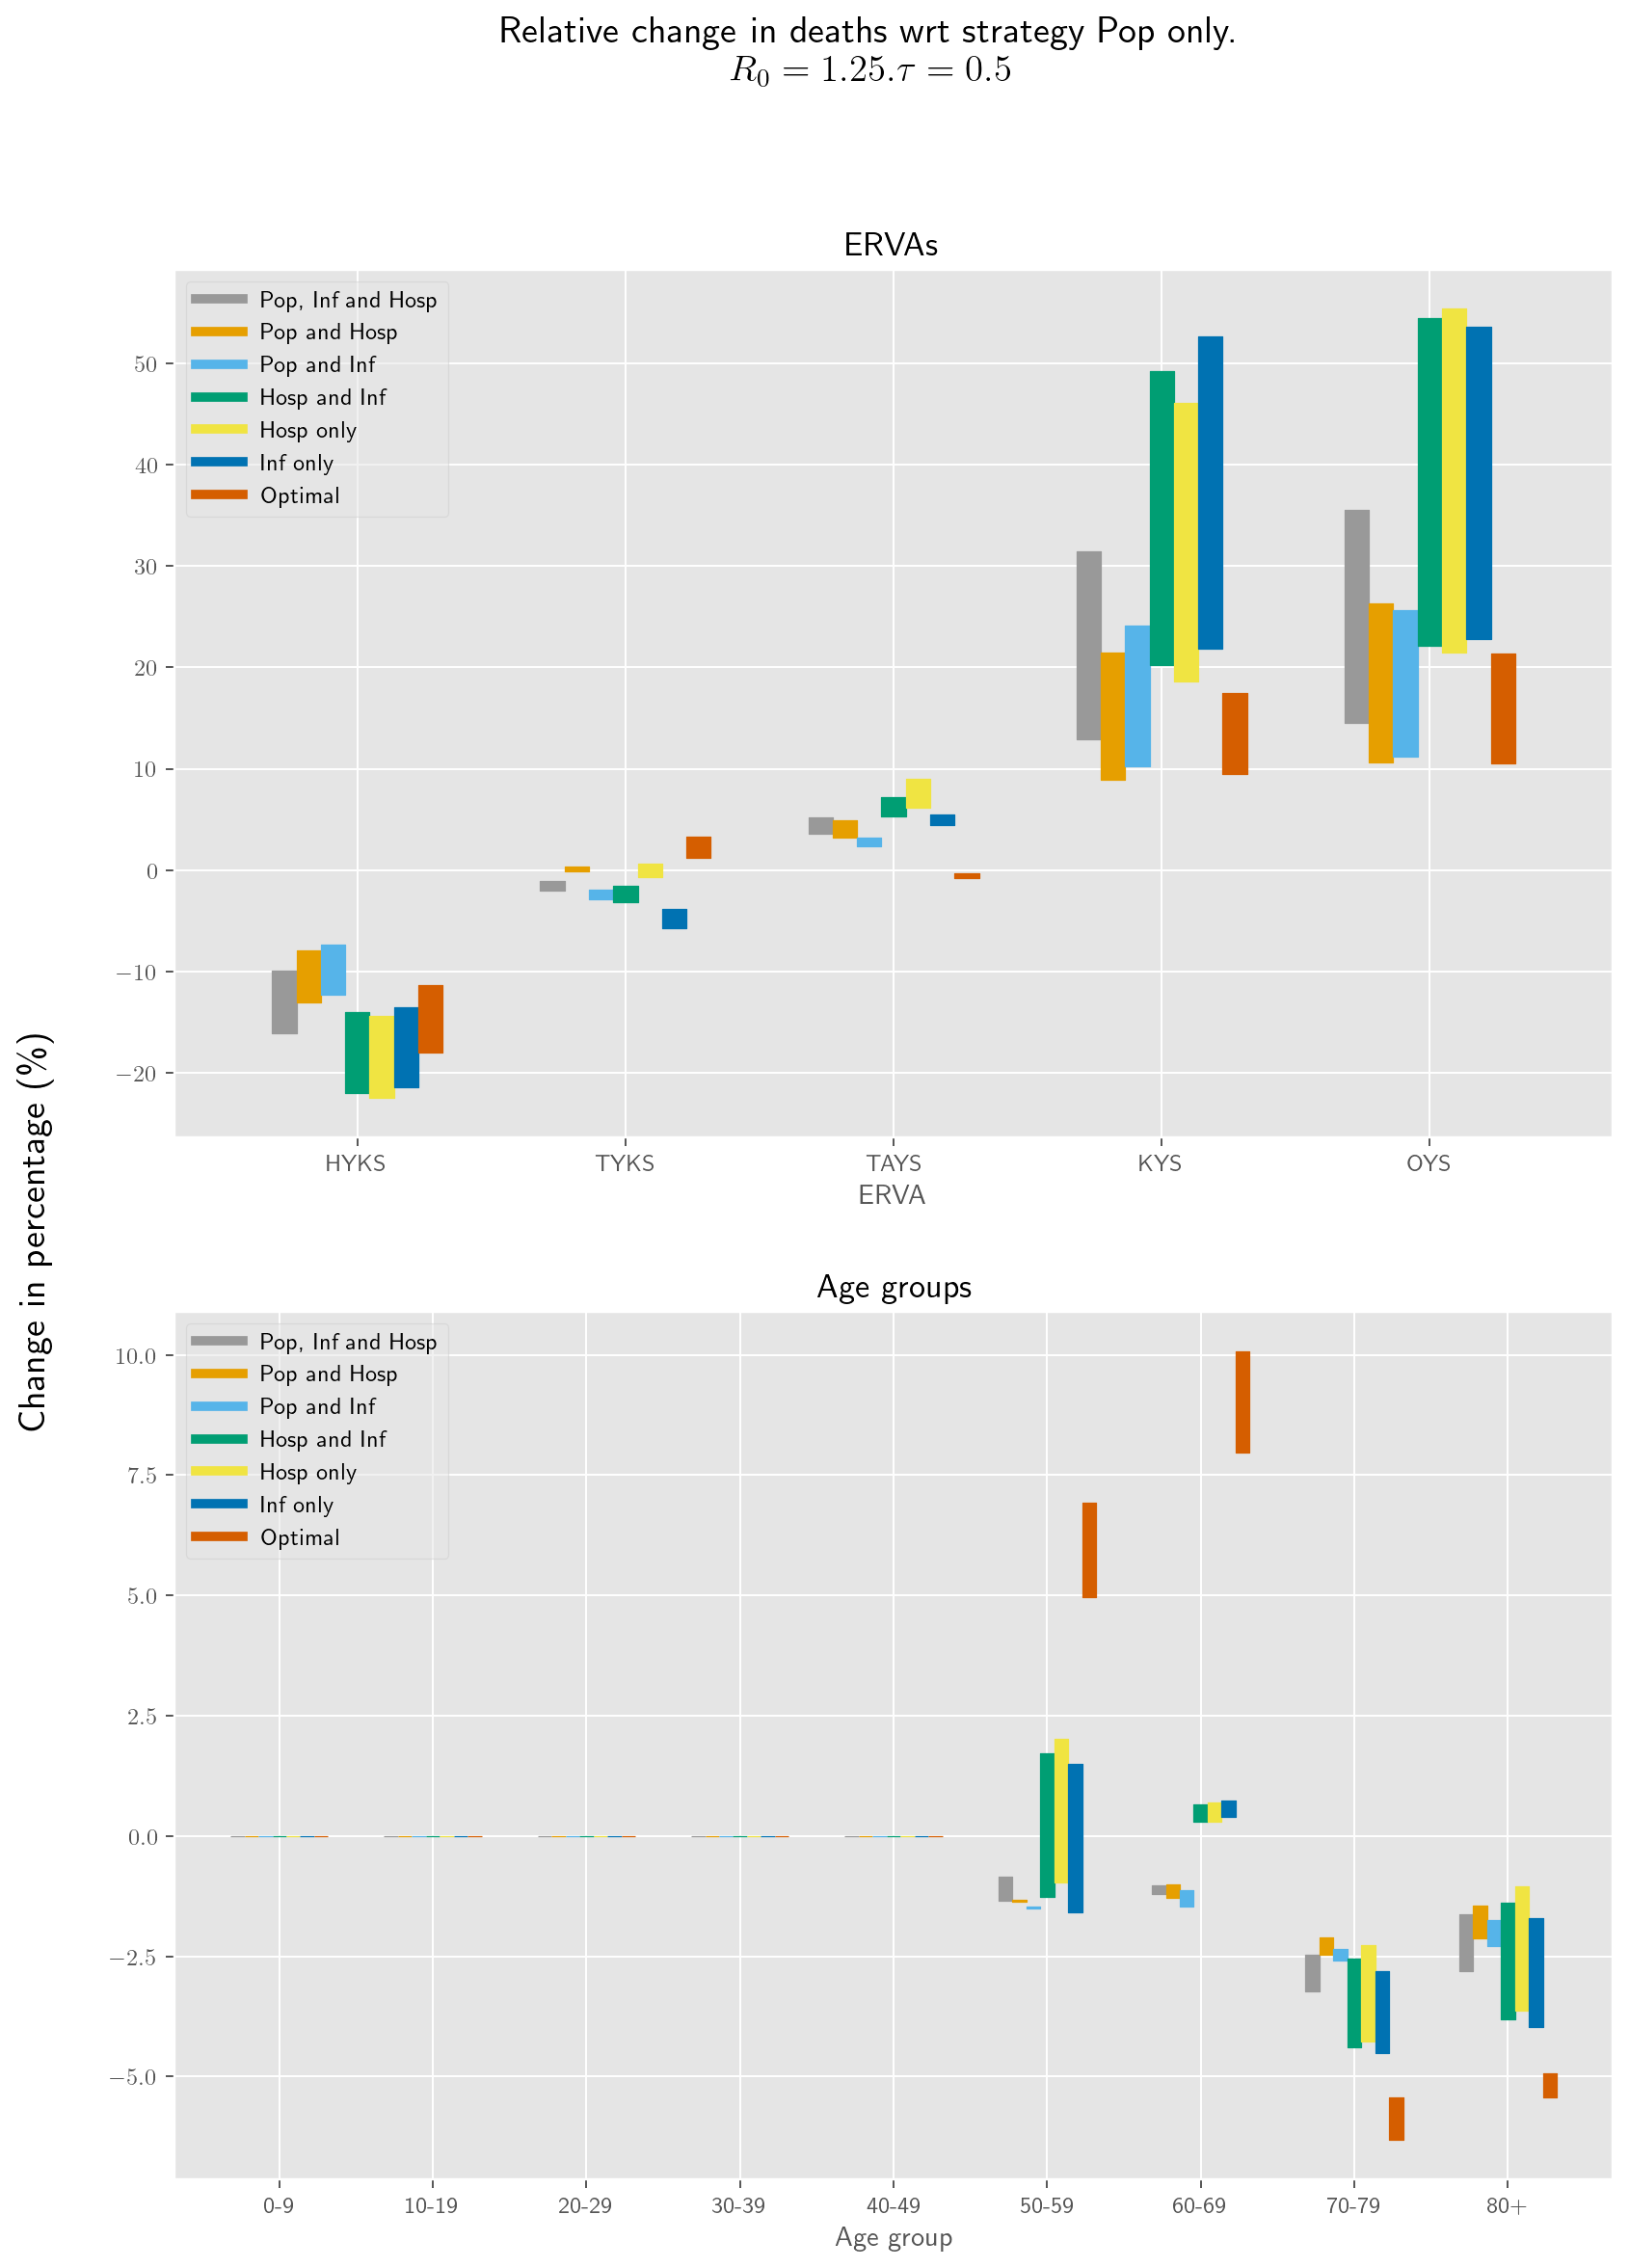

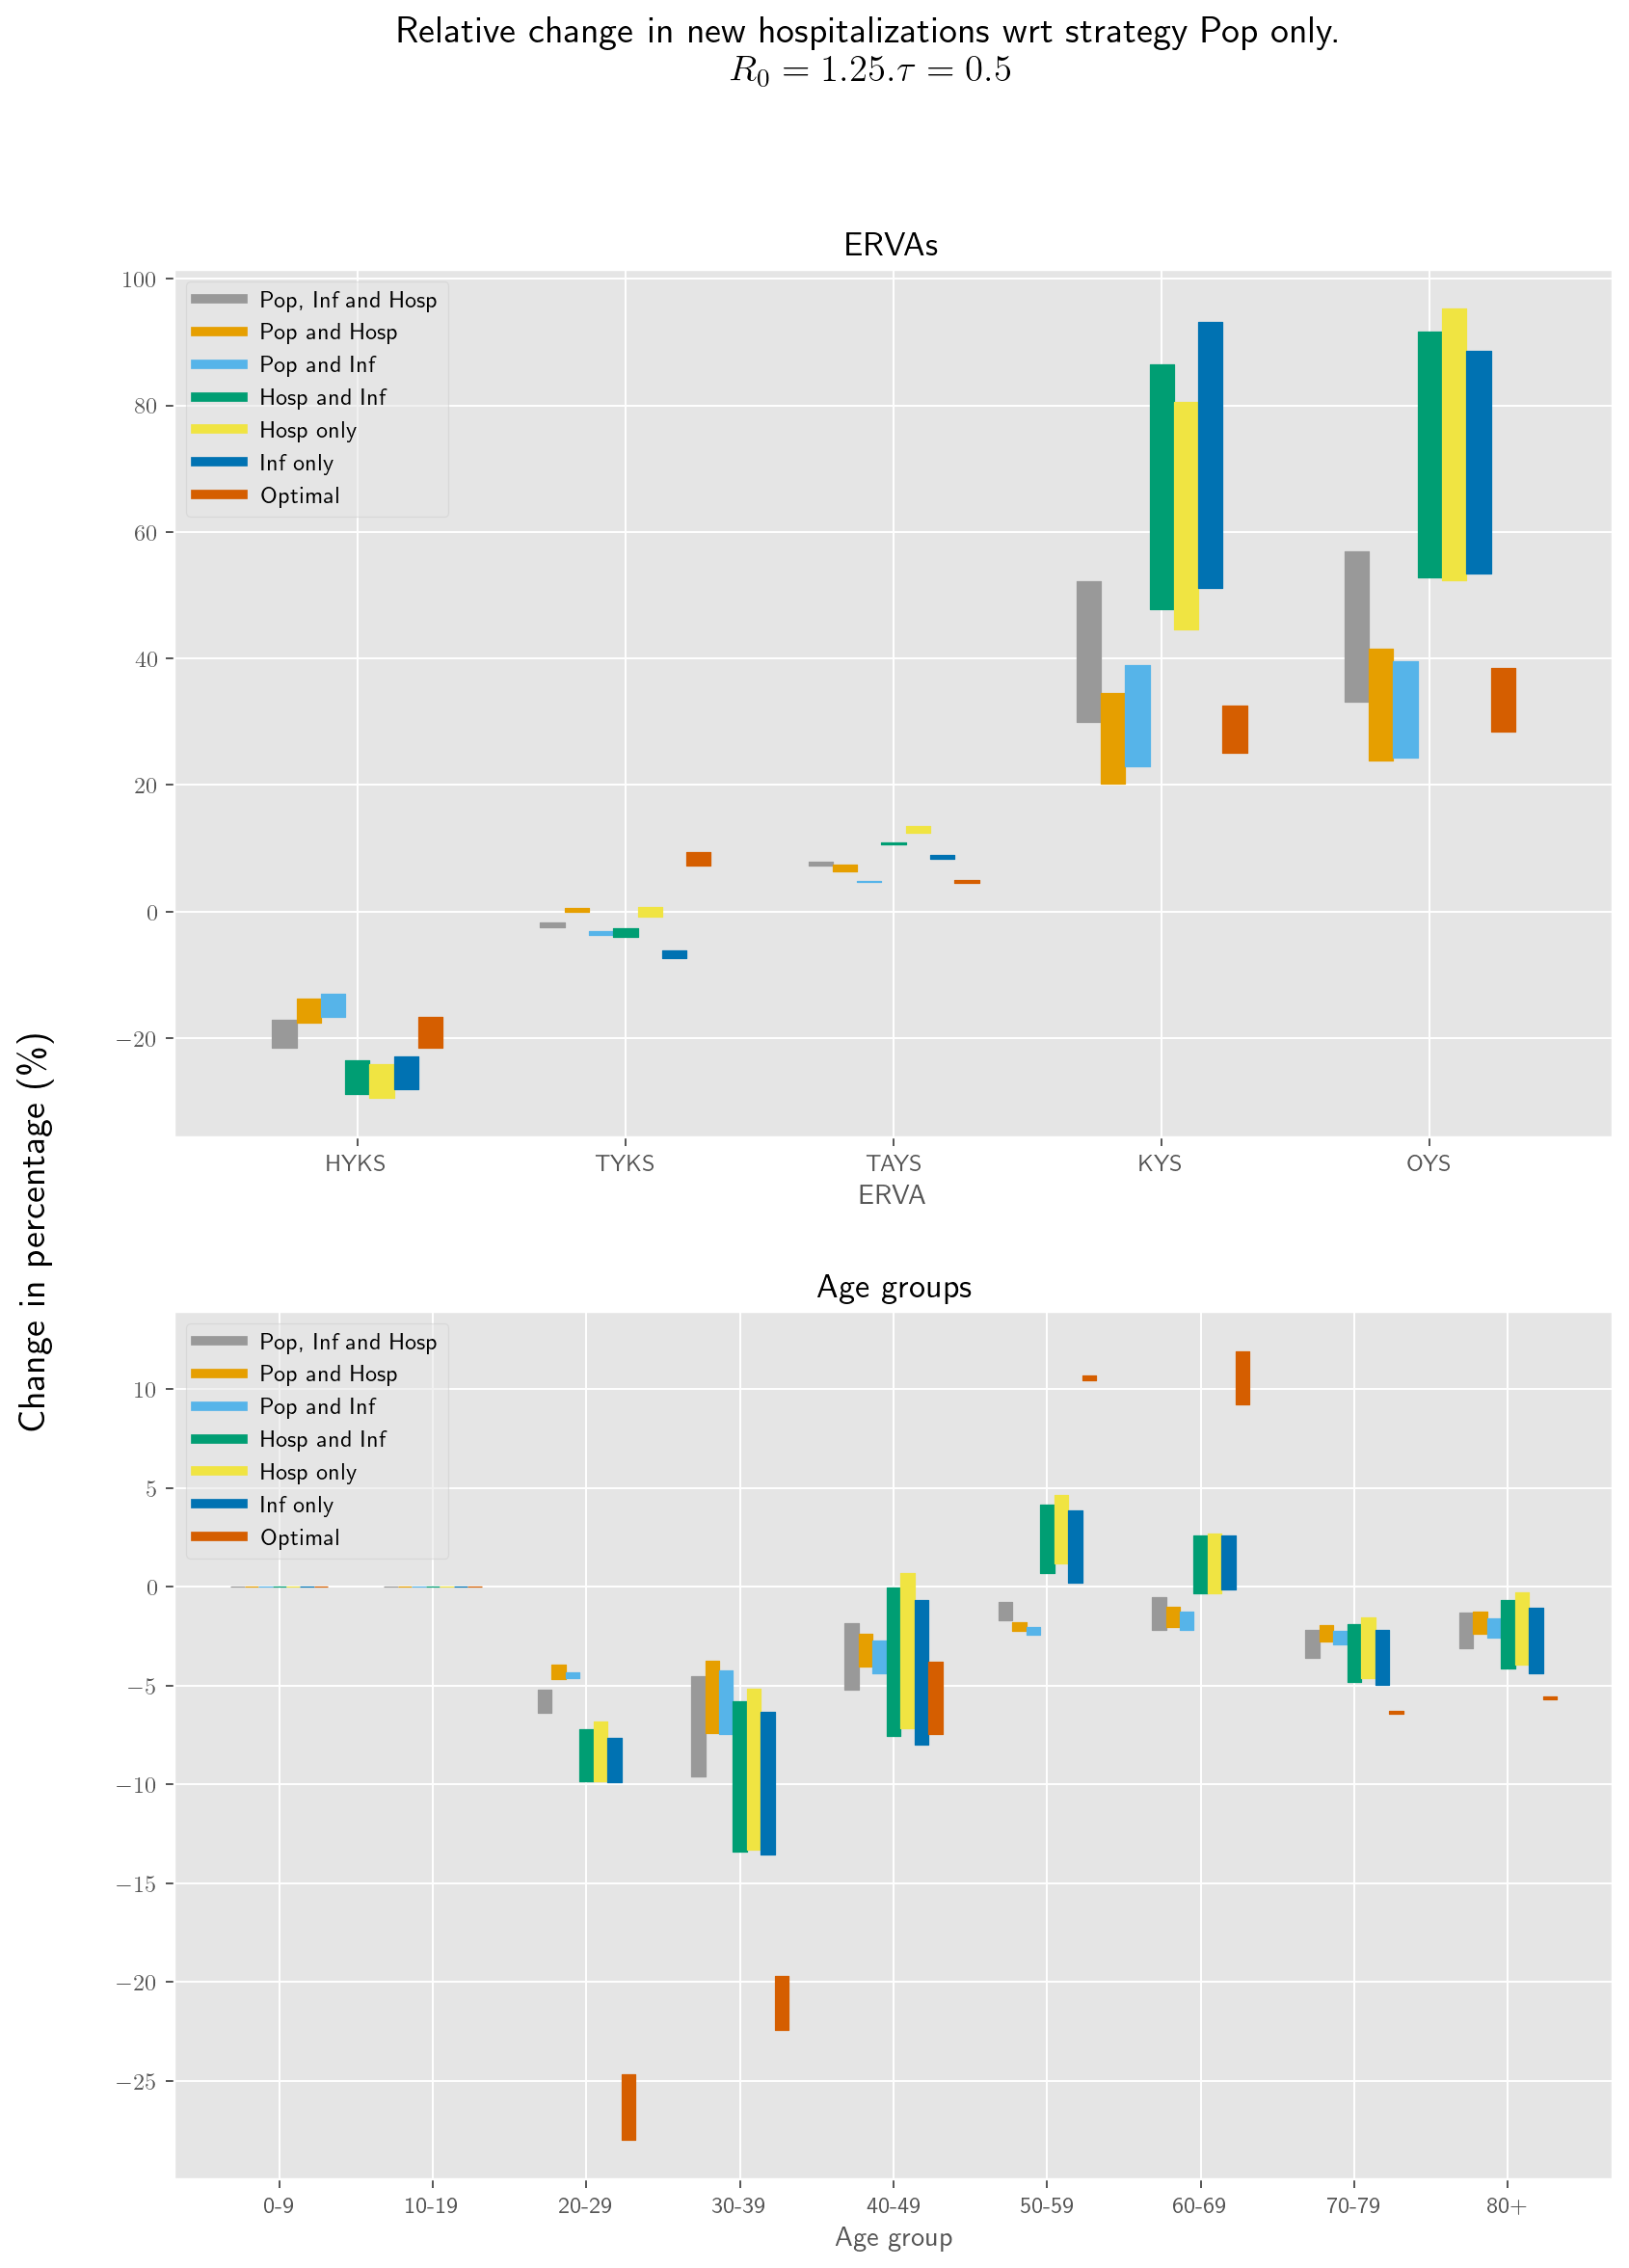

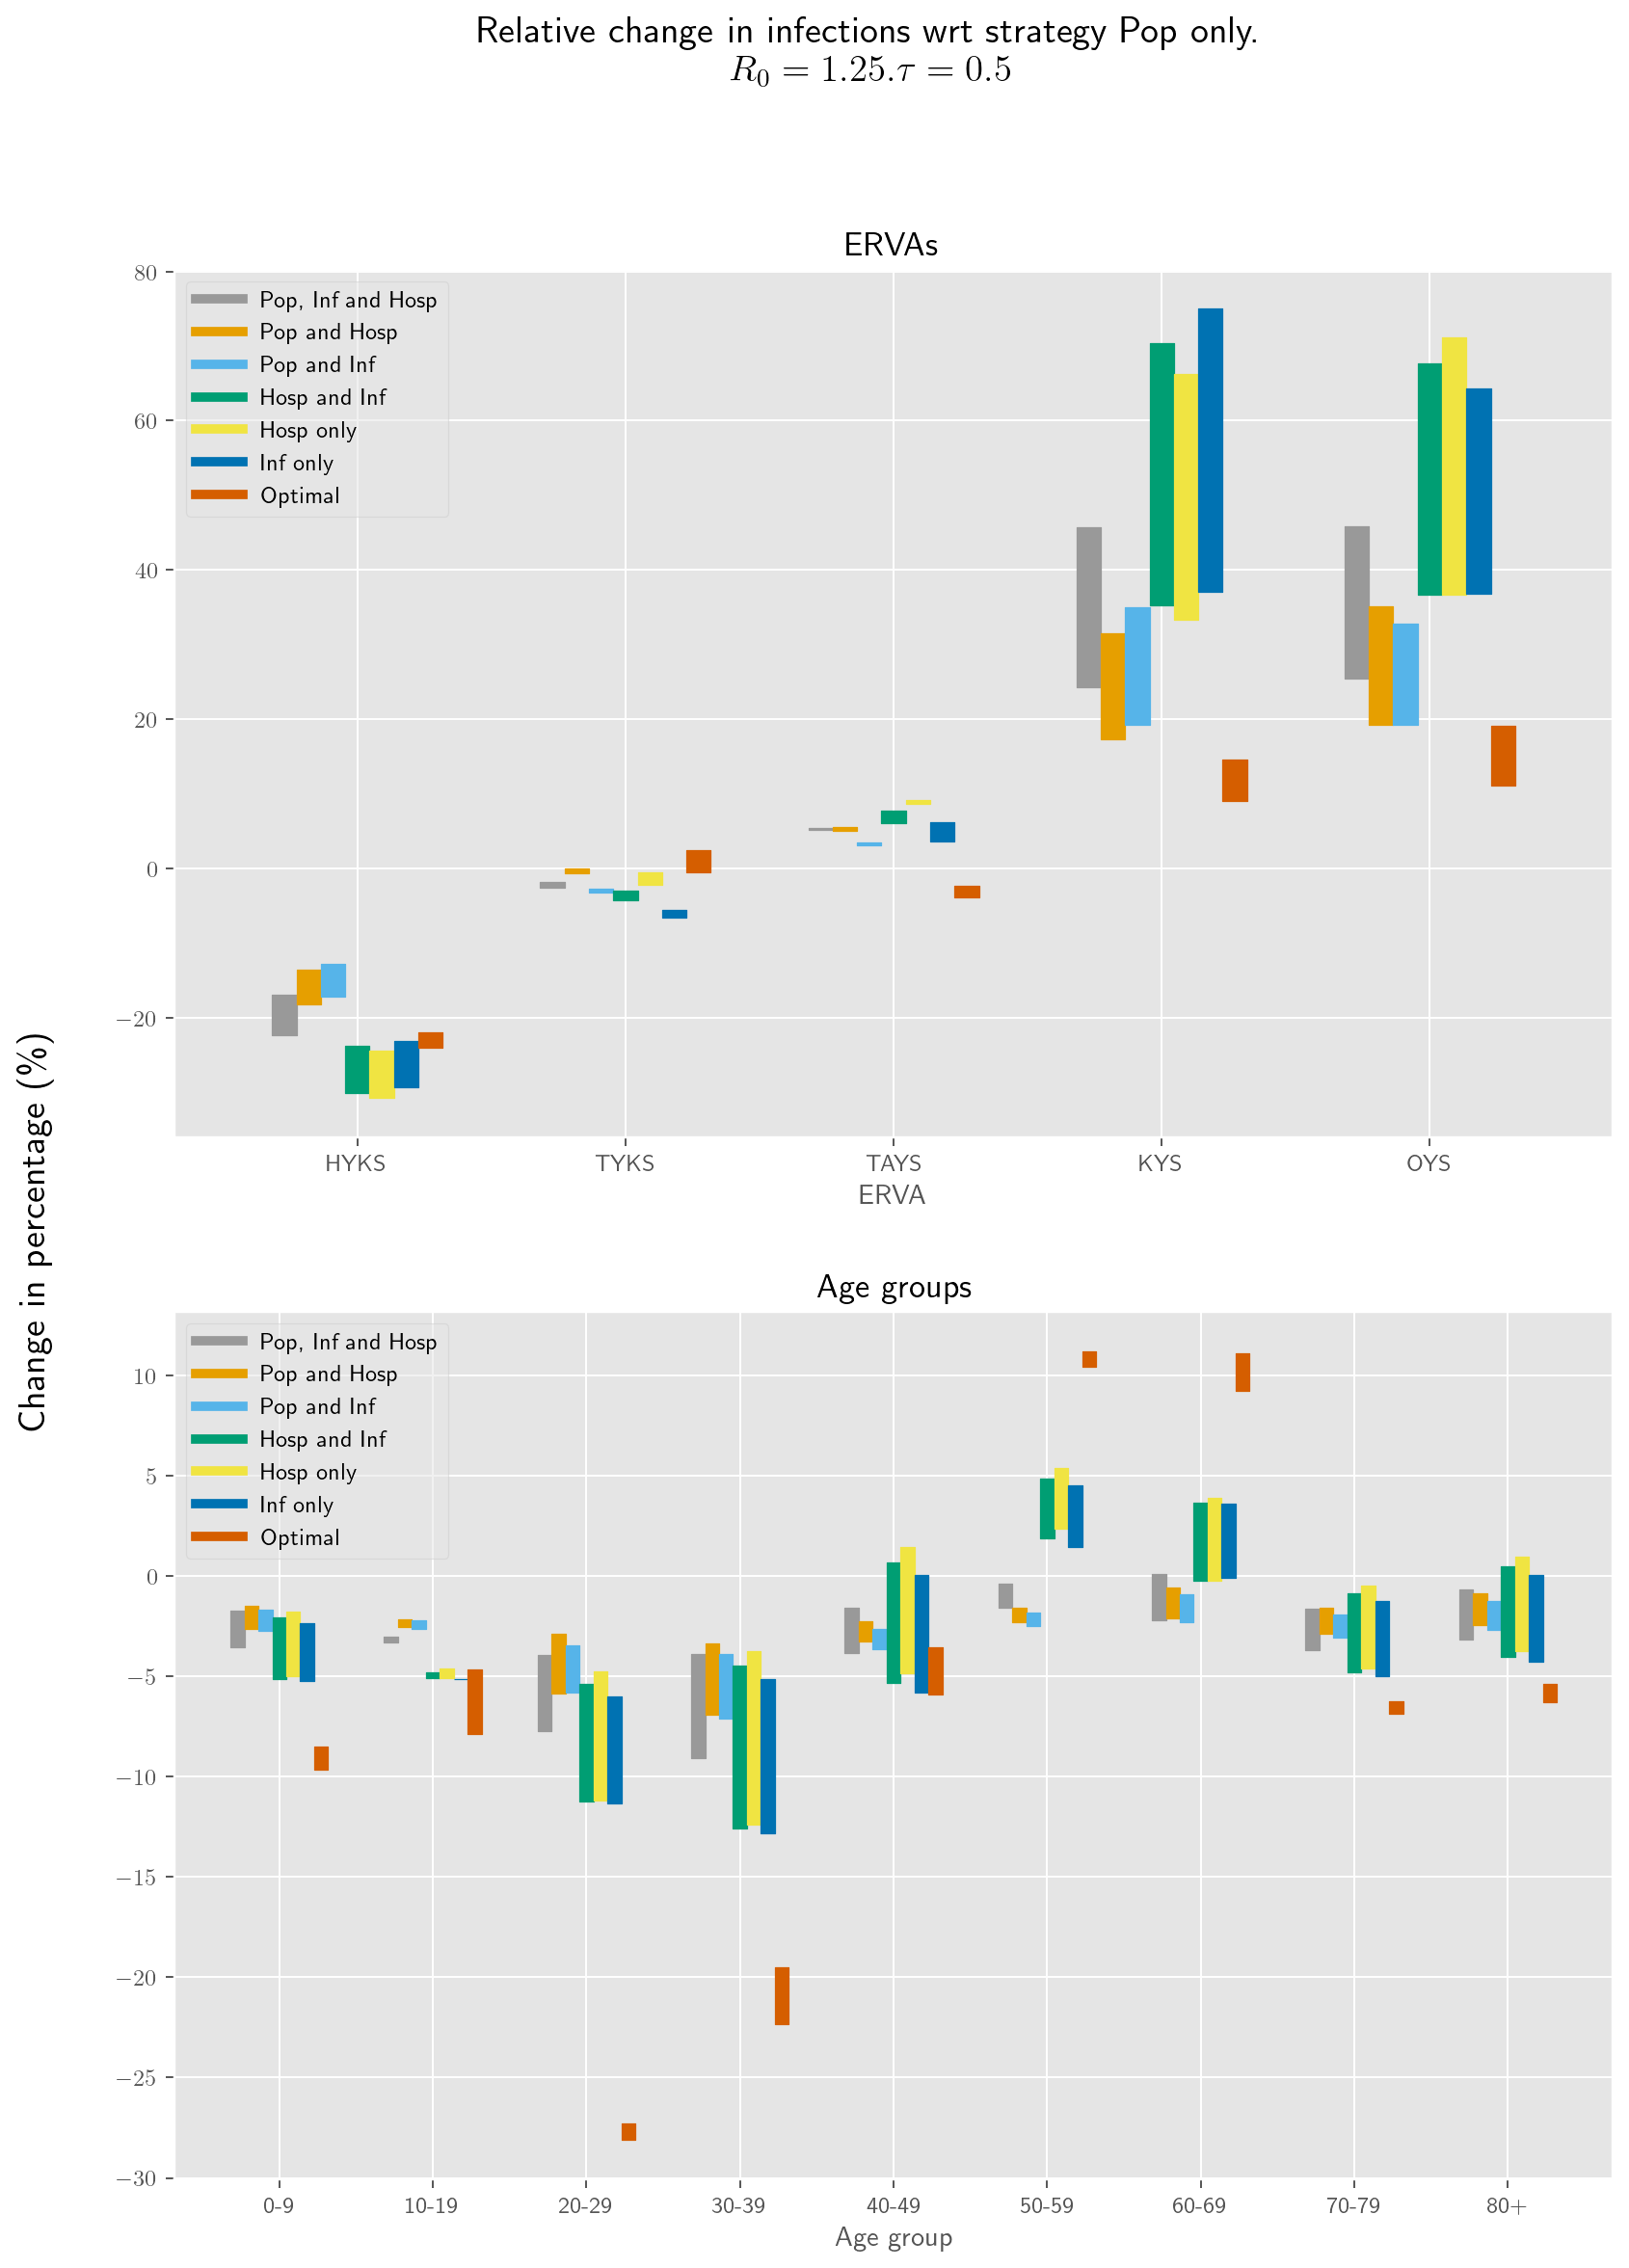

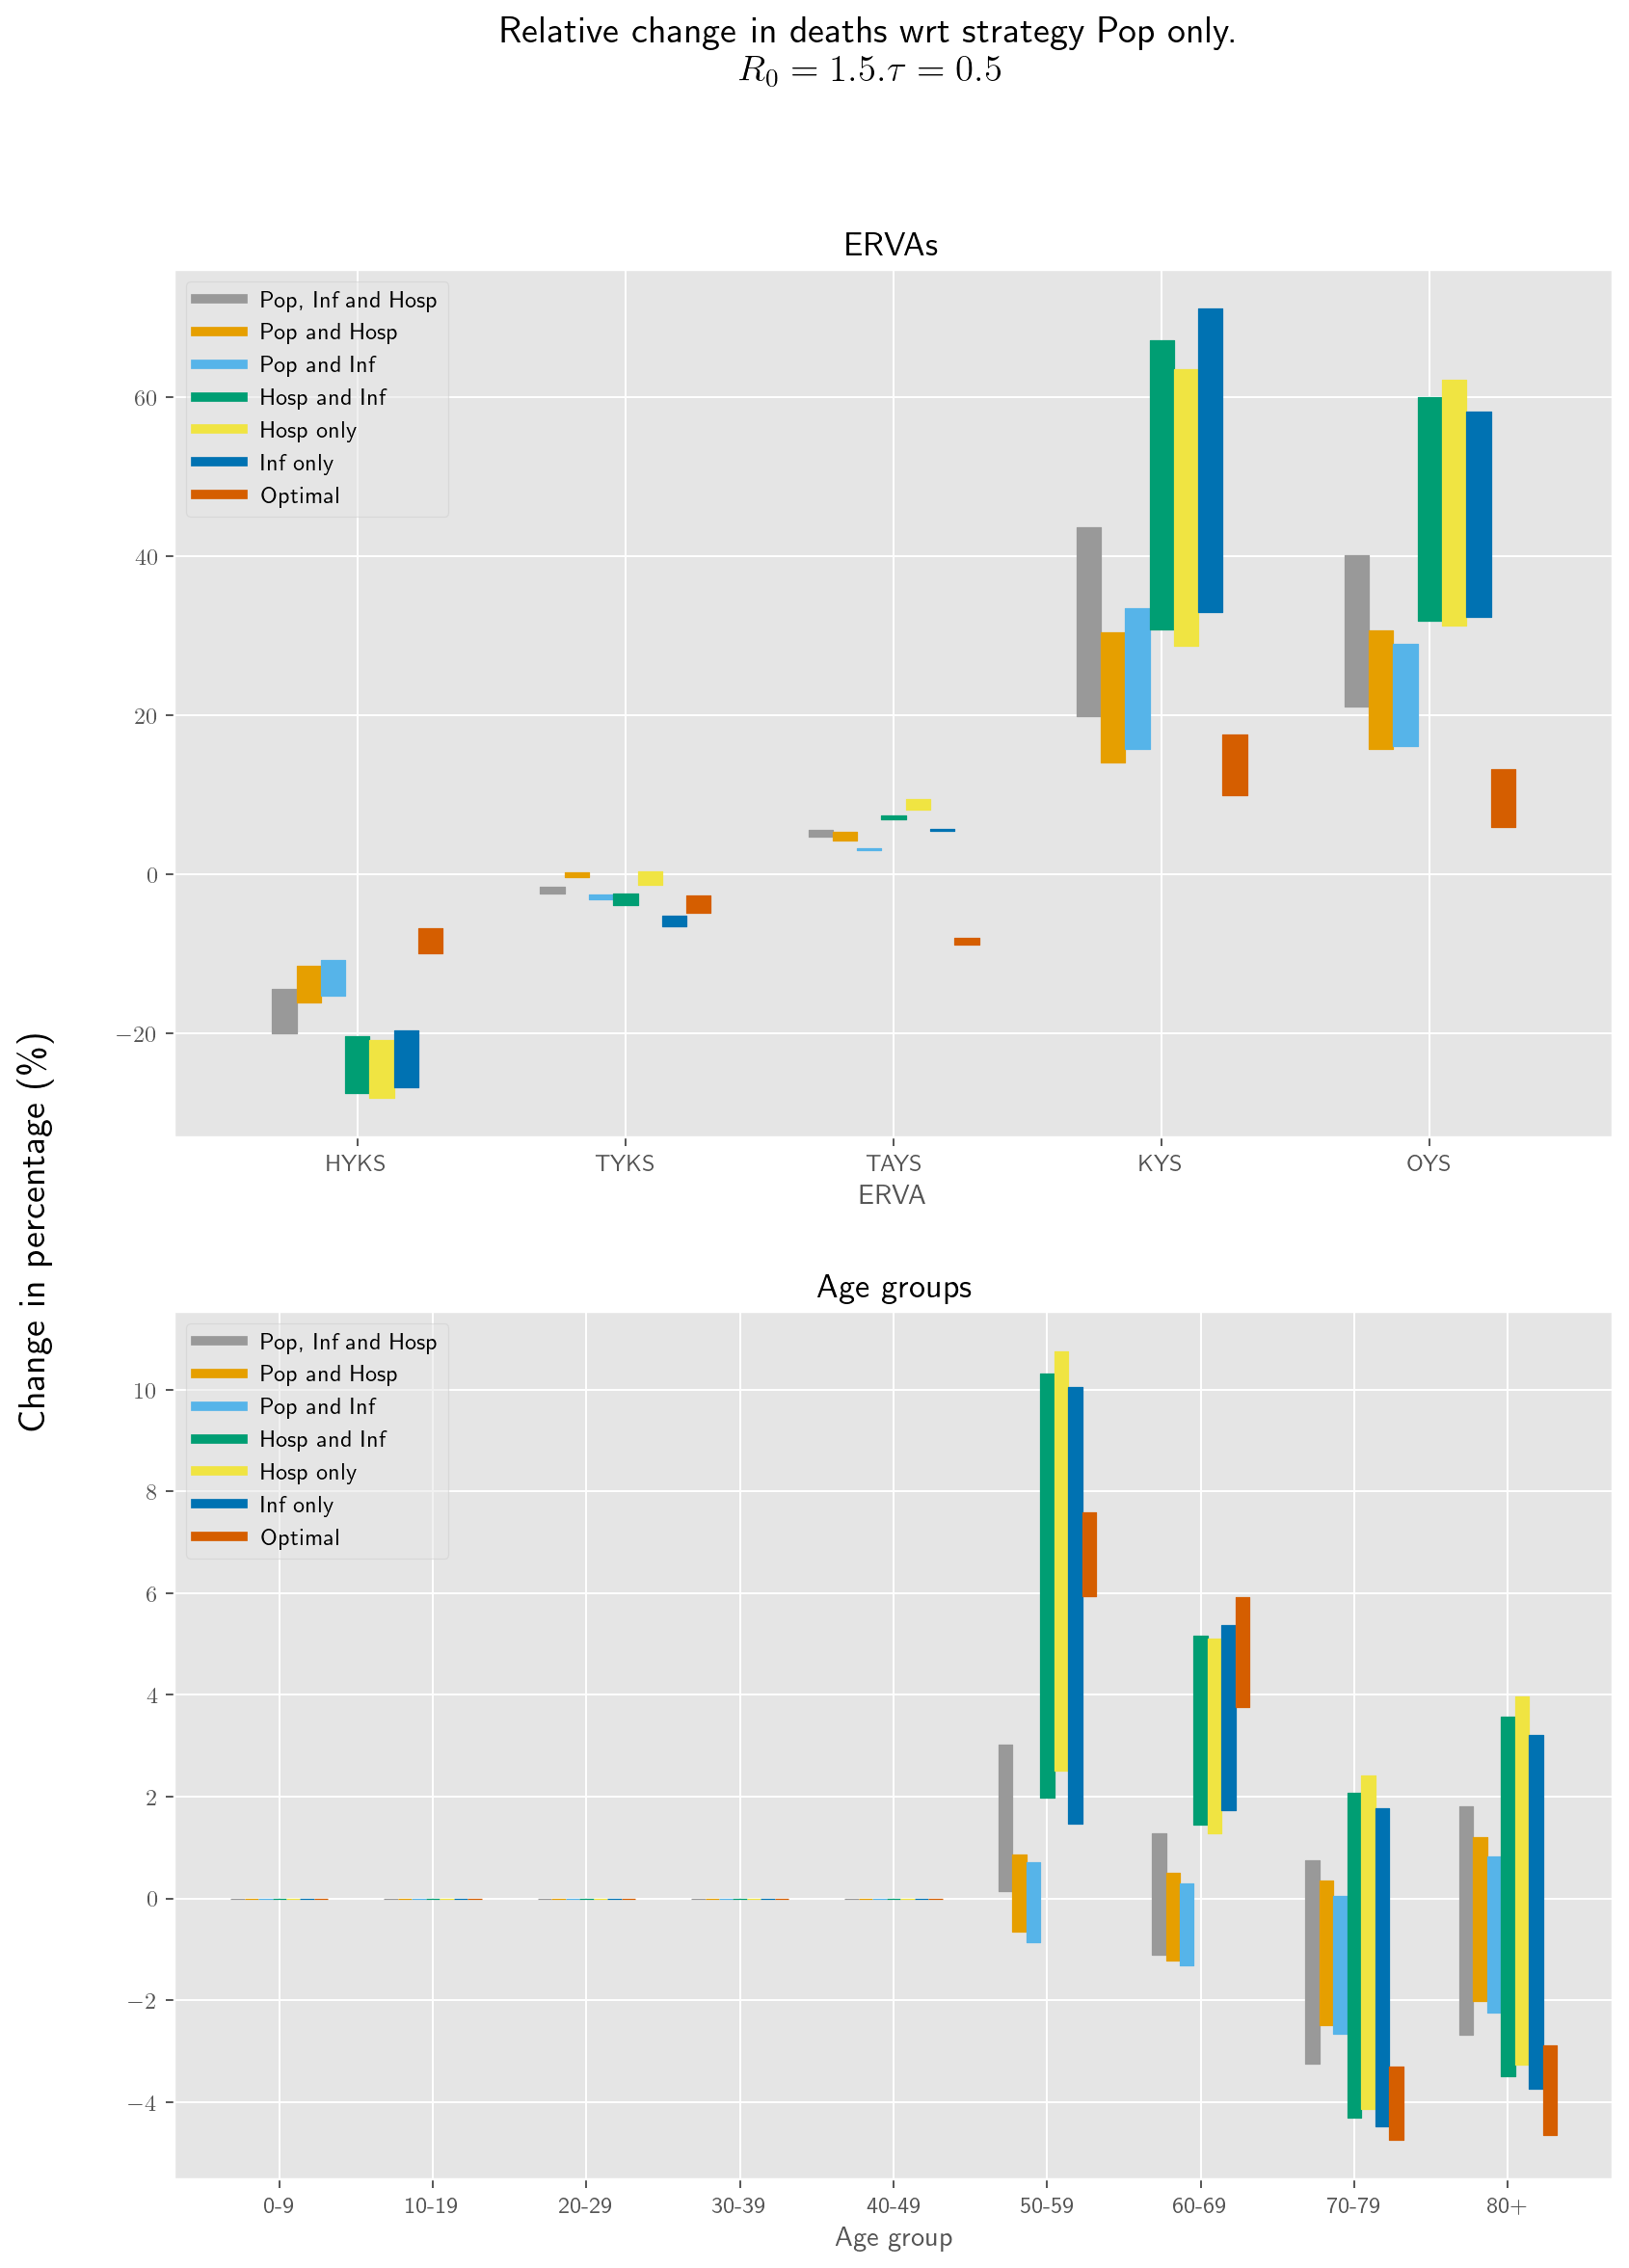

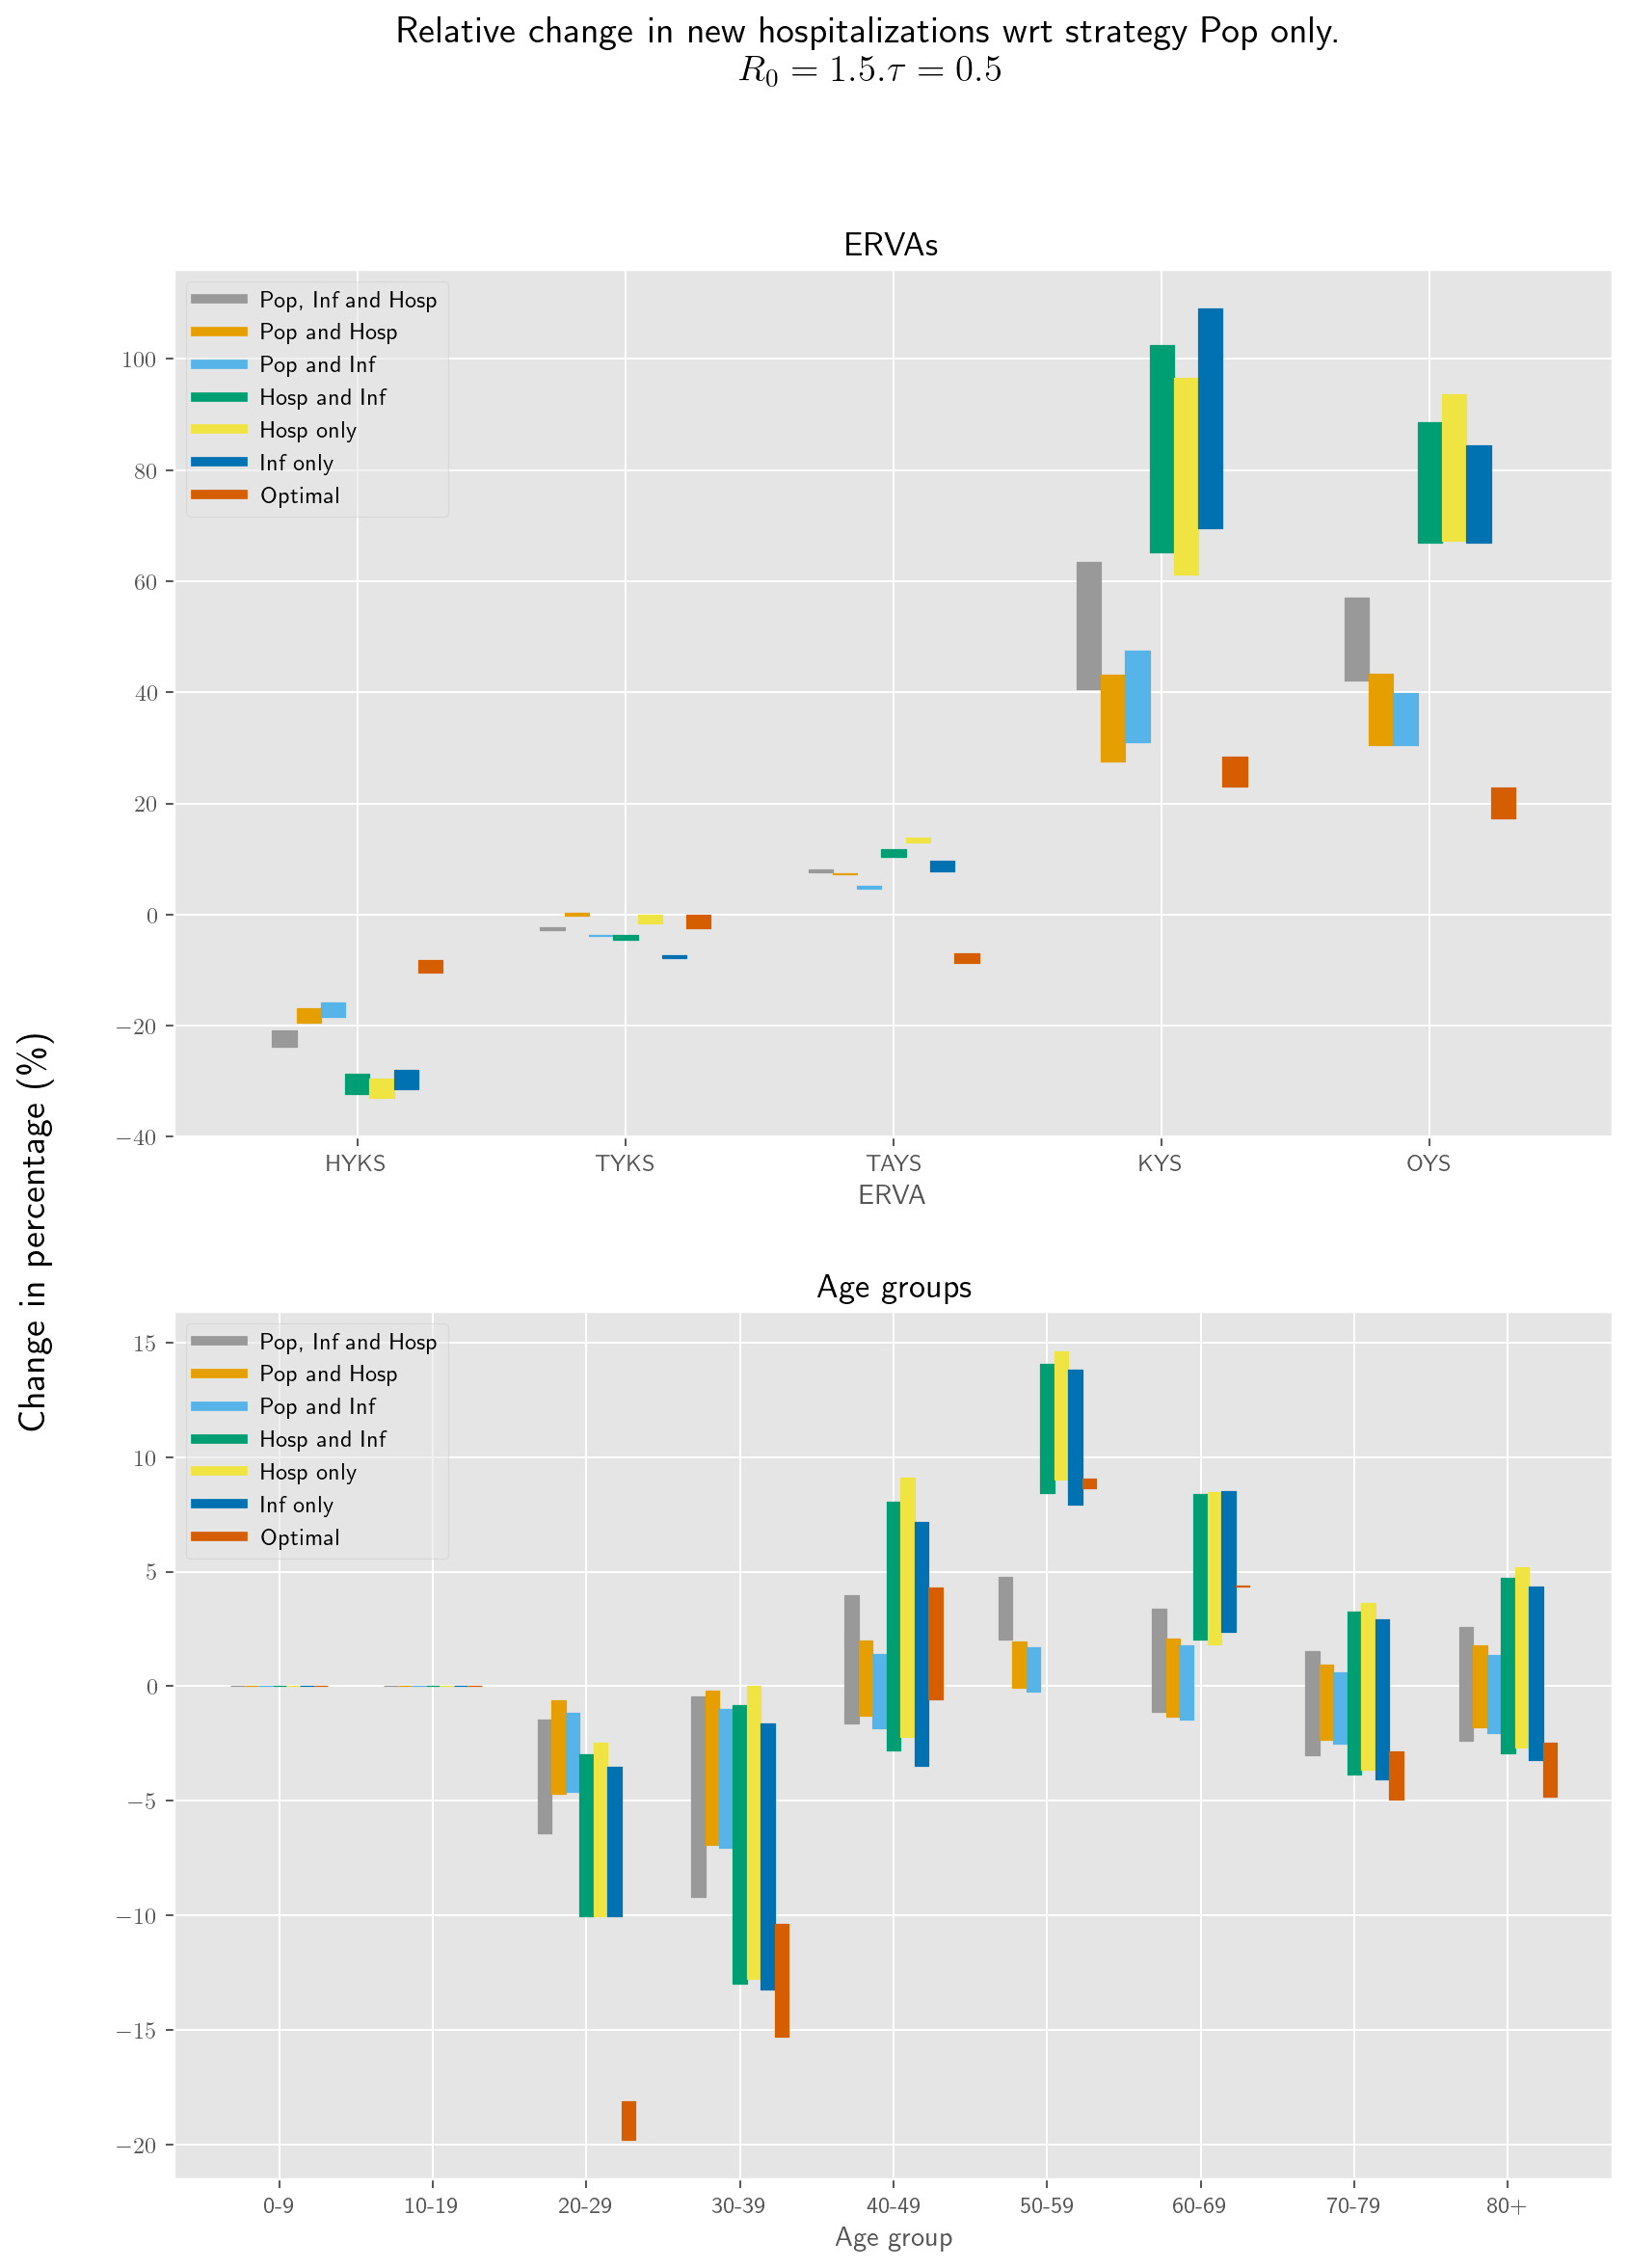

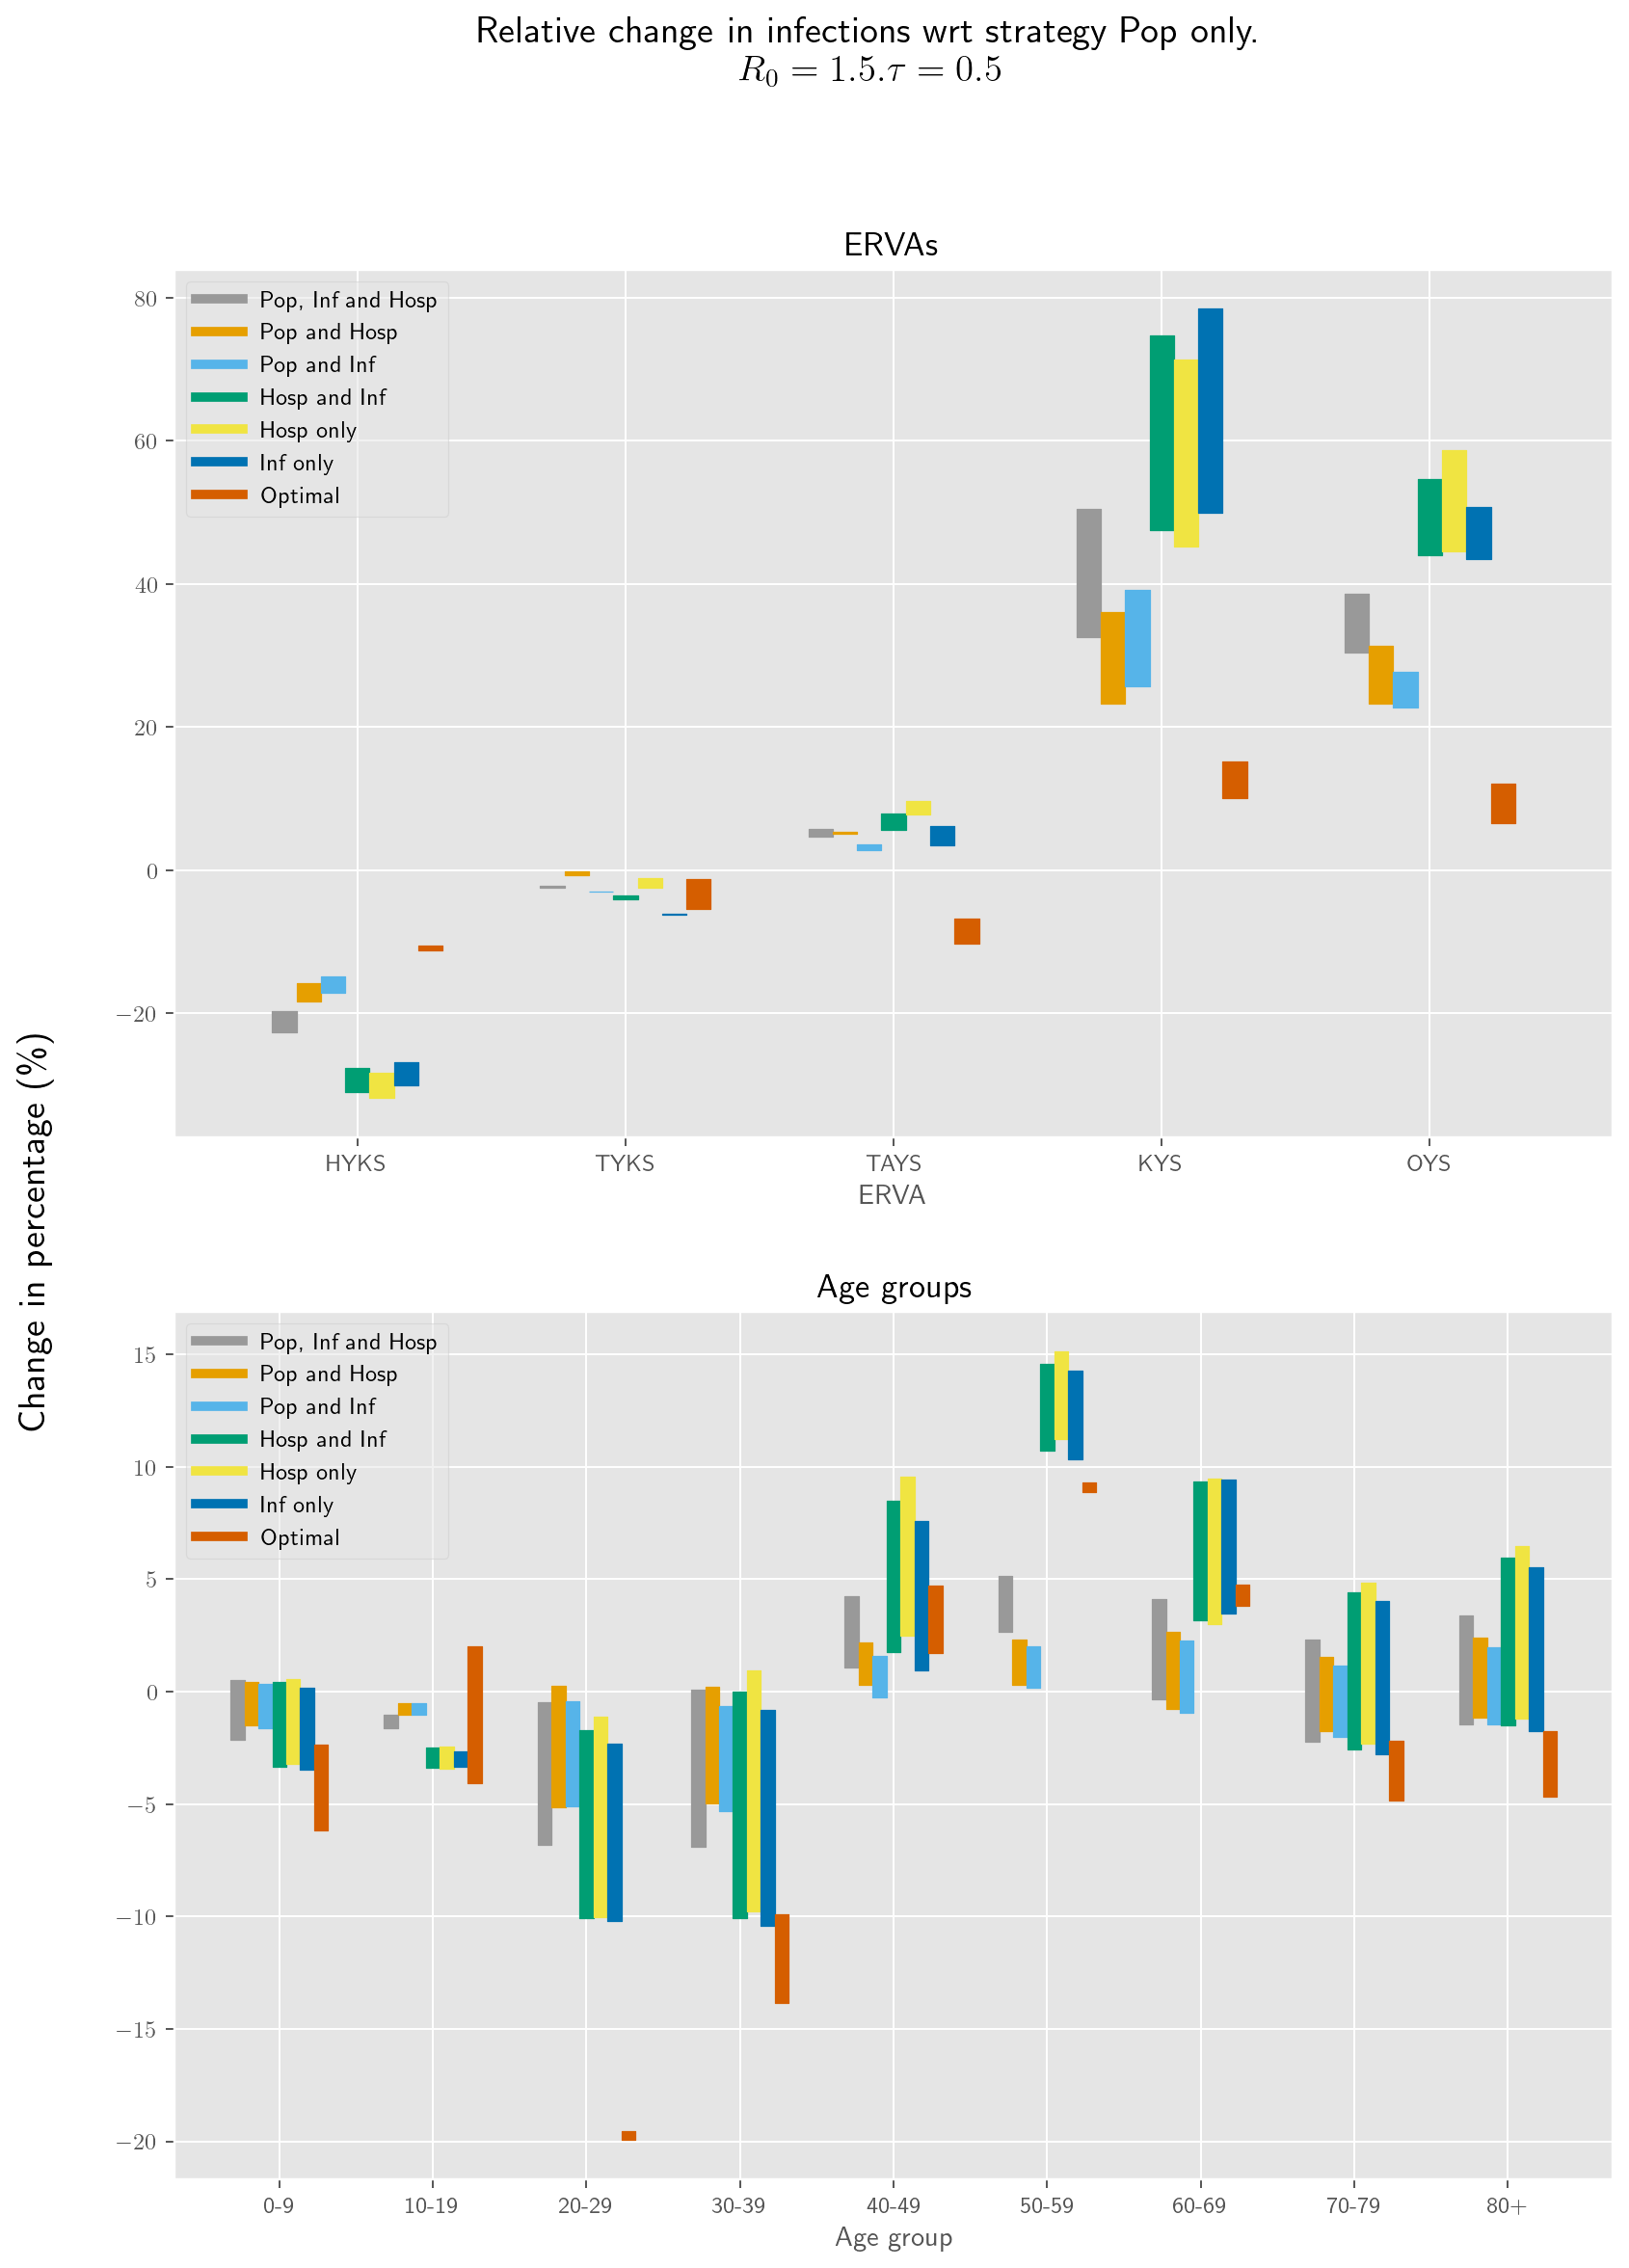

In [12]:
latex_template = """
    \\begin{{figure}}[p]
      \\centering
      \\includegraphics[width=\\textwidth]{{img/{fig_name}}}
      \\caption{{Relative change in {metric} for all vaccination strategies with respect to vaccination strategy {baseline}.
      The bars represent the relative change in cumulative {metric} between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = {r}$ and the mobility value $\\tau = {tau}$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}}
      \\label{{fig:{name}}}
    \\end{{figure}}
"""
metrics = ['deaths', 'new hospitalizations', 'infections']
save_and_generate_latex(r_experiments=r_experiments, taus=[0.5], ervas_labels=ervas_labels, age_labels=age_labels,
                        metrics=metrics, exp_results=exp_results, skip_no_vacc=True,
                        img_dir=os.path.join('out', 'img'), t2=t2, t1=t1, baseline='Pop only',
                        file_format='pdf', latex_template=latex_template, dpis=2000)

In [13]:
def generate_results_table(r_experiments, taus, metric, baseline, exp_results, skip_no_vacc):
    table_dictionary = {}
    all_columns = set()
    for r in r_experiments:
        for tau in taus:
            key = (str(r), str(tau))
            table_dictionary[key] = {}
            results = exp_results[r][tau]
            for label, label_level in results.items():
                if label == baseline:
                    baseline_results = label_level['results'][metric]
                    baseline_results = baseline_results.sum()
                    table_dictionary[key]['baseline'] = {}
                    table_dictionary[key]['baseline']['count'] = baseline_results
                elif label == 'No vaccination' and skip_no_vacc:
                    continue
                else:
                    all_columns.add(label)
                    strategy_results = label_level['results'][metric]
                    strategy_results = strategy_results.sum()
                    table_dictionary[key][label] = {}
                    table_dictionary[key][label]['count'] = strategy_results
                    table_dictionary[key][label]['best'] = False
    
    for key, strategies_level in table_dictionary.items():
        best_strategy_val = np.inf
        last_best = None
        for column in all_columns:
            strategies_level[column]['diff_to_baseline'] = strategies_level[column]['count'] - strategies_level['baseline']['count']
            strategies_level[column]['change_to_baseline'] = strategies_level[column]['count']/strategies_level['baseline']['count'] - 1
            strategies_level[column]['change_to_baseline'] = strategies_level[column]['change_to_baseline']*100
            
            if strategies_level[column]['diff_to_baseline'] < best_strategy_val:
                best_strategy_val = strategies_level[column]['diff_to_baseline']
                strategies_level[column]['best'] = True
                if last_best is not None:
                    strategies_level[last_best]['best'] = False
                    
                last_best = column
            
    header_latex = """
    \\begin{table}[h]
    \\centering
    \\tiny
    \\begin{tabular}{c|%s}
    \\toprule
    """
    header_latex = header_latex % ('c'*len(all_columns))
    header_titles = '\\bf $R_0, \\tau$ '
    for column in all_columns:
        header_titles += '& \\bf %s ' % column
    complete_header = header_latex + header_titles + '\\\\ \n \\midrule \n'
    
    lines_diff = ''
    lines_change = ''
    for key, strategies_level in table_dictionary.items():
        r_str, tau_str = key
        line_diff = '%s, %s ' % (r_str, tau_str)
        line_change = line_diff
        for column in all_columns:
            if strategies_level[column]['best']:
                line_diff += '& \\bf '
                line_change += '& \\bf '
            else:
                line_diff += '& '
                line_change += '& '
            line_diff += '%.2f ' % (round(strategies_level[column]['diff_to_baseline'], 2))
            line_change += '%.2f ' % (round(strategies_level[column]['change_to_baseline'], 2))
        line_diff += ' \\\\ \n'
        line_change += ' \\\\ \n'
        
        lines_diff += line_diff
        lines_change += line_change
        
    tbl_diff = complete_header + lines_diff
    tbl_change = complete_header + lines_change
    
    end_table = """
    \\bottomrule
    \\end{tabular}
    """
    
    tbl_diff += end_table
    tbl_change += end_table
    
    tbl_diff += """
    \\caption{\\label{tab:ResultsRTauDiff} Difference in %s of each vaccination strategy compared to strategy Pop only.
    Each row $p$ contains the results for a pair of parameters $R_0$ and $\\tau$ while each column $s$ for a vaccination strategy.
    The value in cell $p,s$ is the difference in %s between strategy $s$ and Pop only at scenario with parameters $p$.
    The lowest difference at row $p$ is indicated in bold face.}
    \\end{table}
    """
    tbl_diff = tbl_diff % (metric, metric)
    
    tbl_change += """
    \\caption{\\label{tab:ResultsRTauDiff} Relative change in %s with each vaccination strategy compared to strategy Pop only.
    Each row $p$ contains the results for a pair of parameters $R_0$ and $\\tau$ while each column $s$ for a vaccination strategy.
    The value in cell $p,s$ is the relative change in %s with strategy $s$ wrt. Pop only at scenario with parameters $p$.
    The lowest relative change at row $p$ is indicated in bold face.}
    \\end{table}
    """
    tbl_change = tbl_change % (metric, metric)

    return tbl_diff, tbl_change

In [14]:
metrics = ['deaths', 'new hospitalizations', 'infections']
for metric in metrics:
    tbl_diff, tbl_change = generate_results_table(r_experiments, taus, metric=metric, baseline='Pop only',
                                                  exp_results=exp_results, skip_no_vacc=True)
    print(tbl_diff)
    print(tbl_change)


    \begin{table}[h]
    \centering
    \tiny
    \begin{tabular}{c|ccccccc}
    \toprule
    \bf $R_0, \tau$ & \bf Inf only & \bf Optimal & \bf Hosp and Inf & \bf Pop and Inf & \bf Pop, Inf and Hosp & \bf Pop and Hosp & \bf Hosp only \\ 
 \midrule 
0.75, 0 & \bf -0.31 & -0.20 & -0.29 & -0.19 & -0.23 & -0.17 & -0.27  \\ 
0.75, 0.5 & \bf -0.48 & -0.34 & -0.46 & -0.29 & -0.35 & -0.26 & -0.43  \\ 
0.75, 1.0 & \bf -0.73 & -0.54 & -0.71 & -0.43 & -0.53 & -0.40 & -0.68  \\ 
1.0, 0 & \bf -2.10 & -1.81 & -1.95 & -1.41 & -1.61 & -1.25 & -1.78  \\ 
1.0, 0.5 & \bf -3.90 & -3.83 & -3.72 & -2.53 & -2.97 & -2.34 & -3.50  \\ 
1.0, 1.0 & \bf -7.61 & -7.59 & -7.44 & -4.59 & -5.62 & -4.41 & -7.23  \\ 
1.25, 0 & -3.94 & \bf -16.56 & -2.35 & -5.59 & -4.55 & -4.12 & -0.61  \\ 
1.25, 0.5 & -12.75 & \bf -32.34 & -11.03 & -12.27 & -12.14 & -10.62 & -9.13  \\ 
1.25, 1.0 & -42.84 & \bf -58.72 & -41.52 & -29.01 & -33.86 & -27.72 & -40.07  \\ 
1.5, 0 & 60.70 & \bf -50.10 & 69.35 & 13.58 & 33.20 & 22.15 & 78.91  